In [1]:
import pandas as pd
import numpy as np
import wfdb
import ast
import sklearn

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [3]:
path = 'ptb-xl/'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass

# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

### Fixing Y data for proper training format

In [4]:
mlb = MultiLabelBinarizer()
y_train_enc = mlb.fit_transform(y_train)
y_test_enc = mlb.fit_transform(y_test)
print("Encoded Labels (y_encoded):\n", y_train_enc)
print("\nClass Names (Order of Columns):\n", mlb.classes_)

Encoded Labels (y_encoded):
 [[0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 ...
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 1 0]]

Class Names (Order of Columns):
 ['CD' 'HYP' 'MI' 'NORM' 'STTC']


# Model Training

## Model structure

In [5]:
# THis is the number of classes. For Superclass it will be 5, if we do all of or a subset of the subclasses there can be more or less.
NUM_CLASSES = 5

# The input shape for the dataset
IN_SHAPE = (1000,12)

model = Sequential([
    Input(IN_SHAPE),
    Conv1D(filters=32, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    # Dropout(0.5),
    Dense(NUM_CLASSES, activation='sigmoid')]
)

## Compiling and Fitting

In [6]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', # could also use categorical_crossentropy here for a single choice per input. Change output to softmax if doing that approach though
    metrics=['accuracy', tf.keras.metrics.AUC(multi_label=True)]
)

In [7]:
model.fit(X_train, y_train_enc)

613/613 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.5869 - auc: 0.8284 - loss: 0.3962


## Testing

In [8]:
loss, accuracy, auc_score = model.evaluate(X_test, y_test_enc, verbose=1)

# Print the results
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc_score:.4f}")

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6260 - auc: 0.8662 - loss: 0.3618
Test Loss: 0.3618
Test Accuracy: 0.6260
Test AUC: 0.8662


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

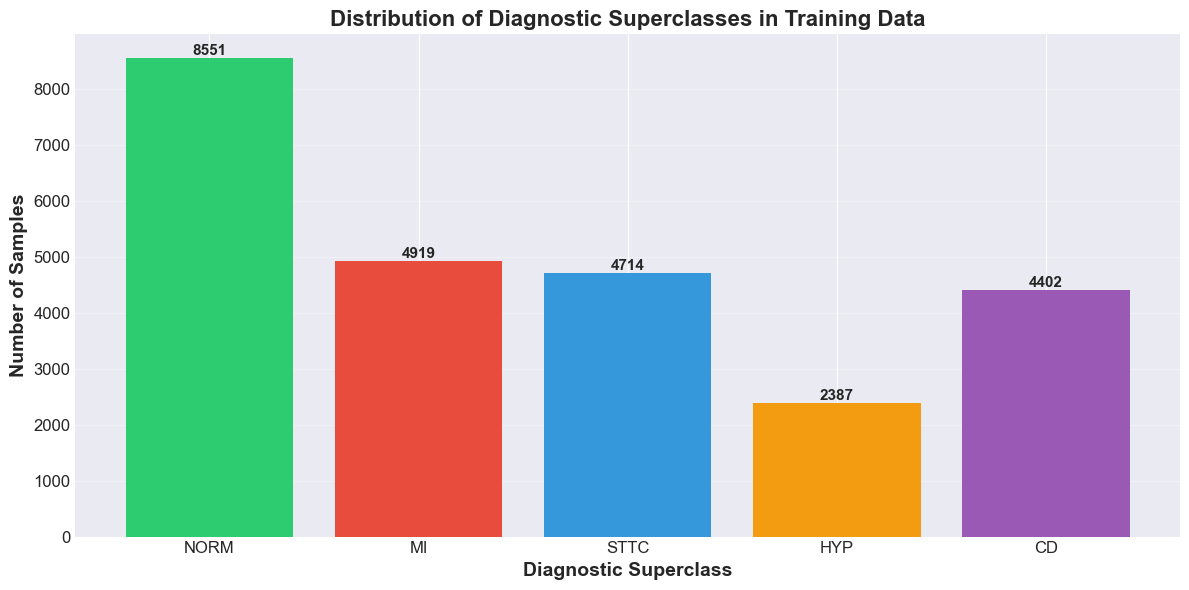


Class Distribution:
NORM: 8551 samples (43.63%)
MI: 4919 samples (25.10%)
STTC: 4714 samples (24.05%)
HYP: 2387 samples (12.18%)
CD: 4402 samples (22.46%)


In [11]:
# Count samples per diagnostic superclass
class_counts = Counter()
for classes in y_train:
    for cls in classes:
        class_counts[cls] += 1

# Create bar plot
plt.figure(figsize=(12, 6))
classes = list(class_counts.keys())
counts = list(class_counts.values())

bars = plt.bar(classes, counts, color=['#2ecc71', '#e74c3c', '#3498db', '#f39c12', '#9b59b6'])
plt.xlabel('Diagnostic Superclass', fontsize=14, fontweight='bold')
plt.ylabel('Number of Samples', fontsize=14, fontweight='bold')
plt.title('Distribution of Diagnostic Superclasses in Training Data', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nClass Distribution:")
for cls, count in class_counts.items():
    percentage = (count / len(y_train)) * 100
    print(f"{cls}: {count} samples ({percentage:.2f}%)")

Plotting sample ECGs from each diagnostic superclass...



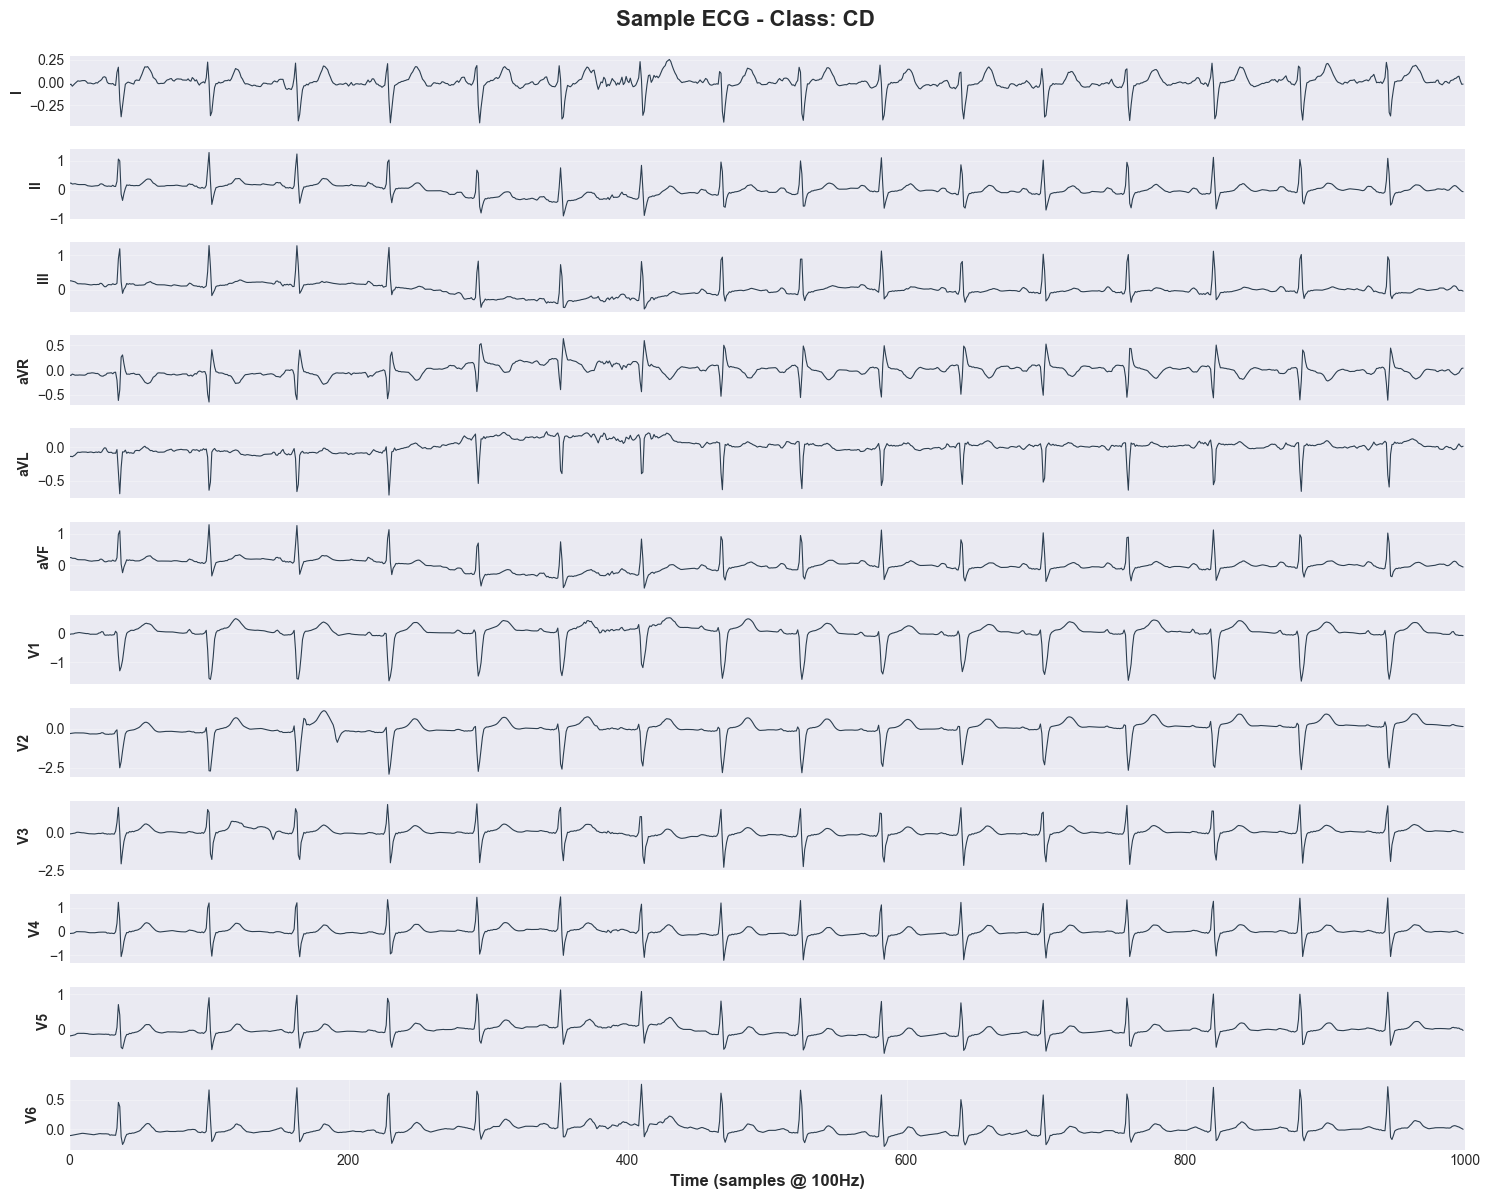

✓ Plotted sample for class: CD


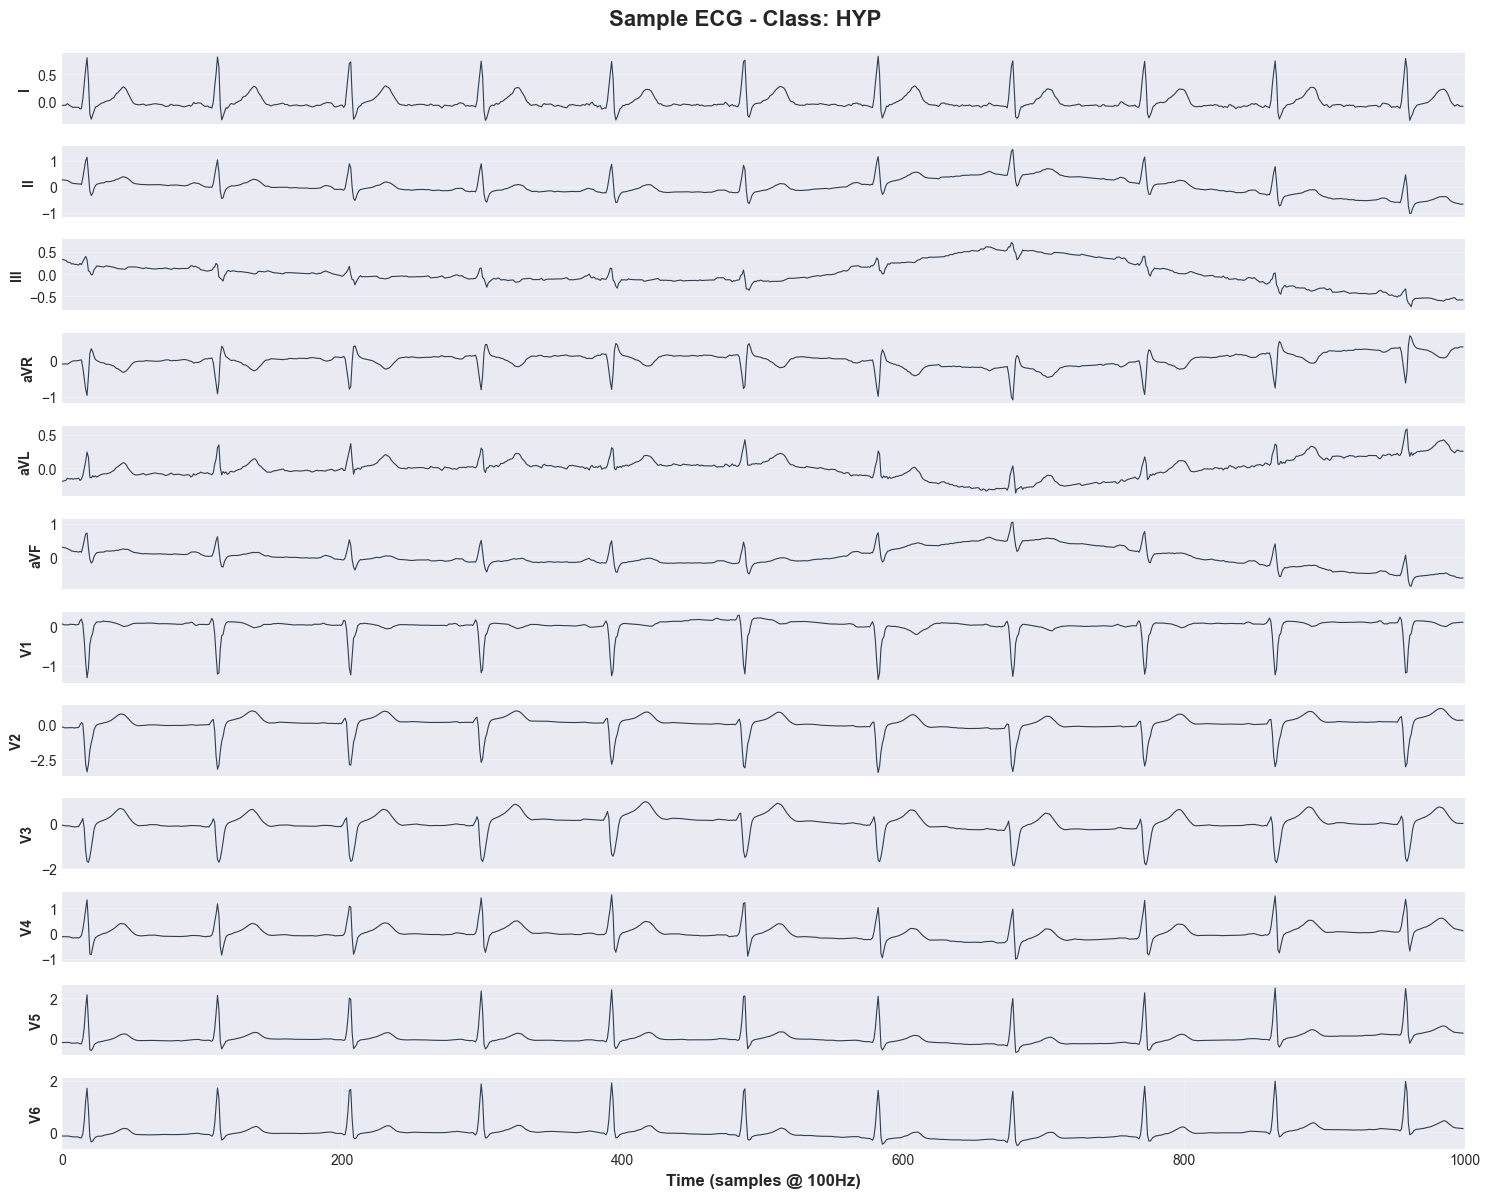

✓ Plotted sample for class: HYP


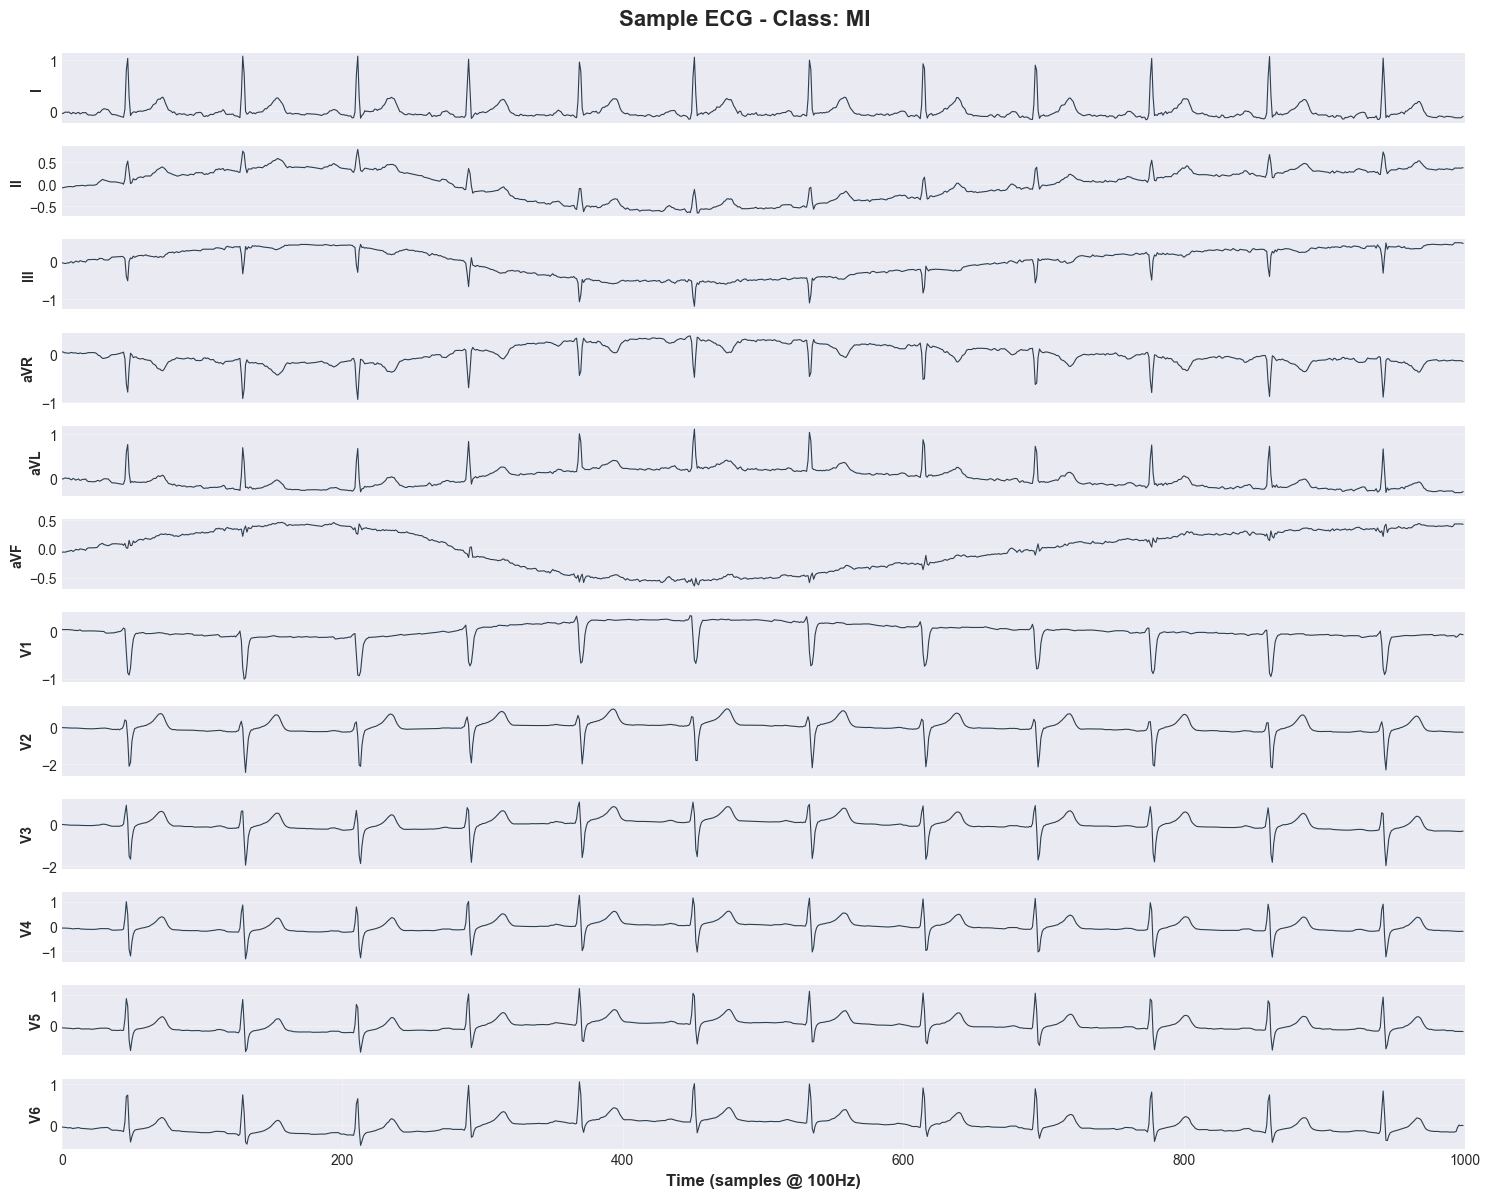

✓ Plotted sample for class: MI


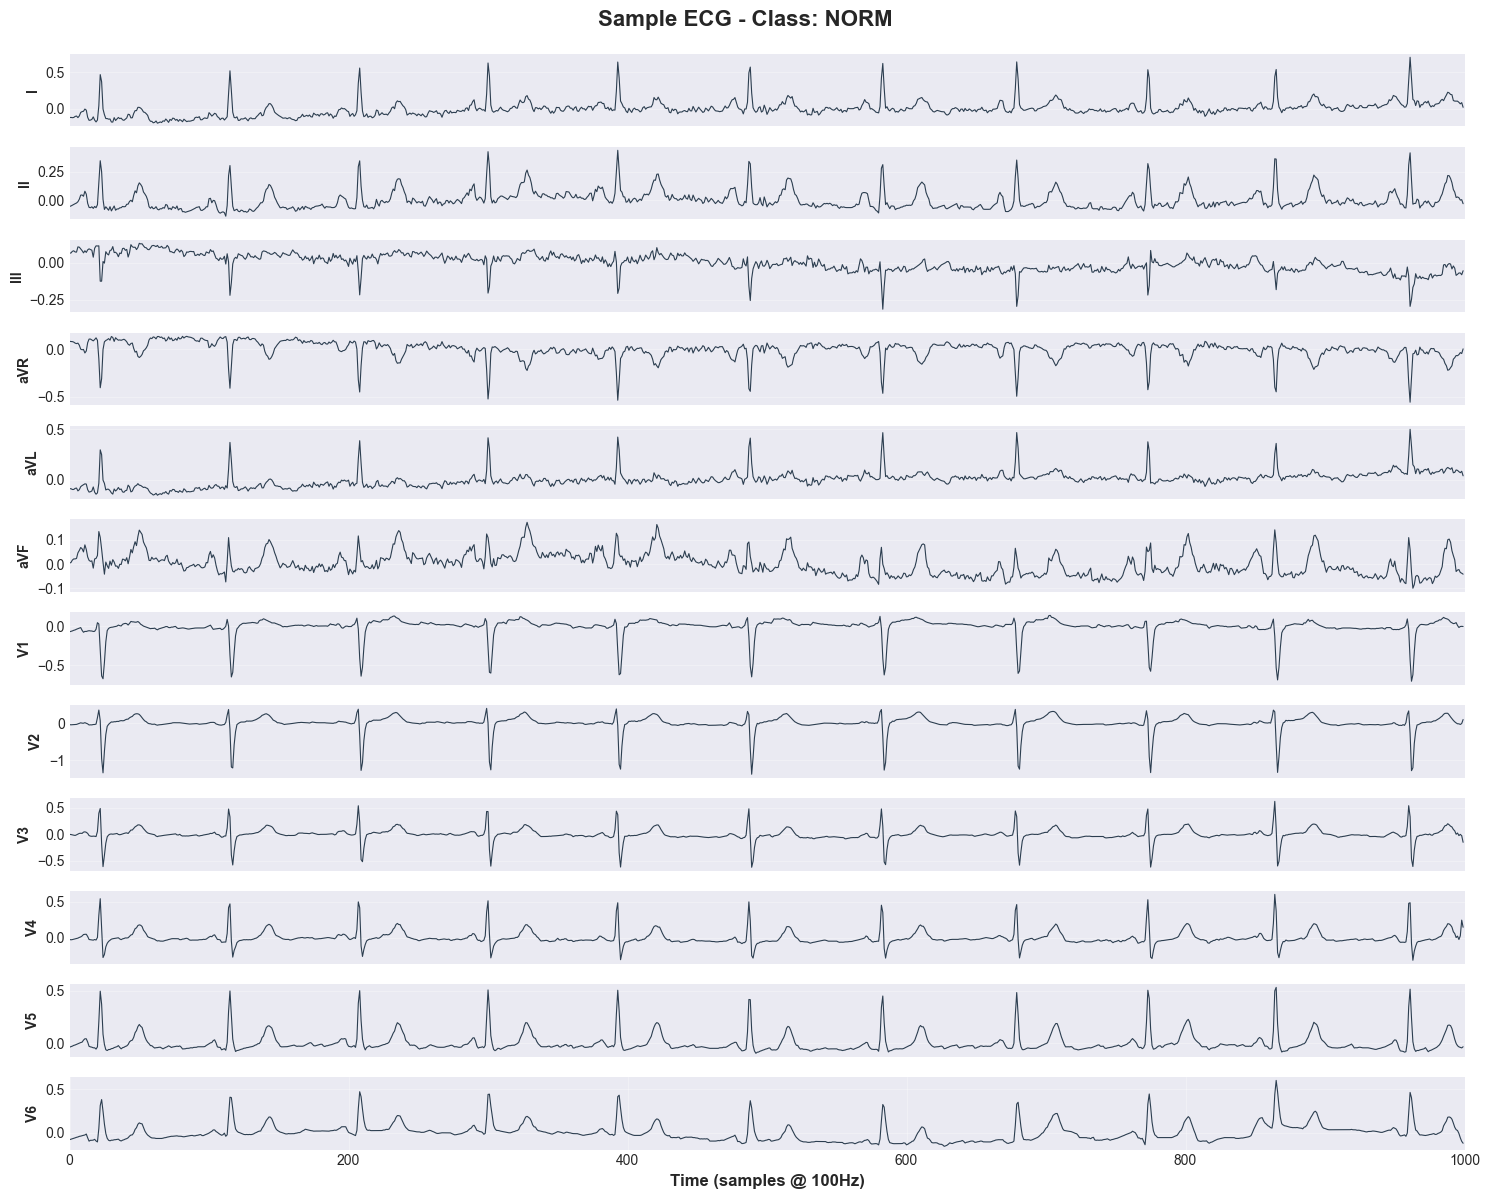

✓ Plotted sample for class: NORM


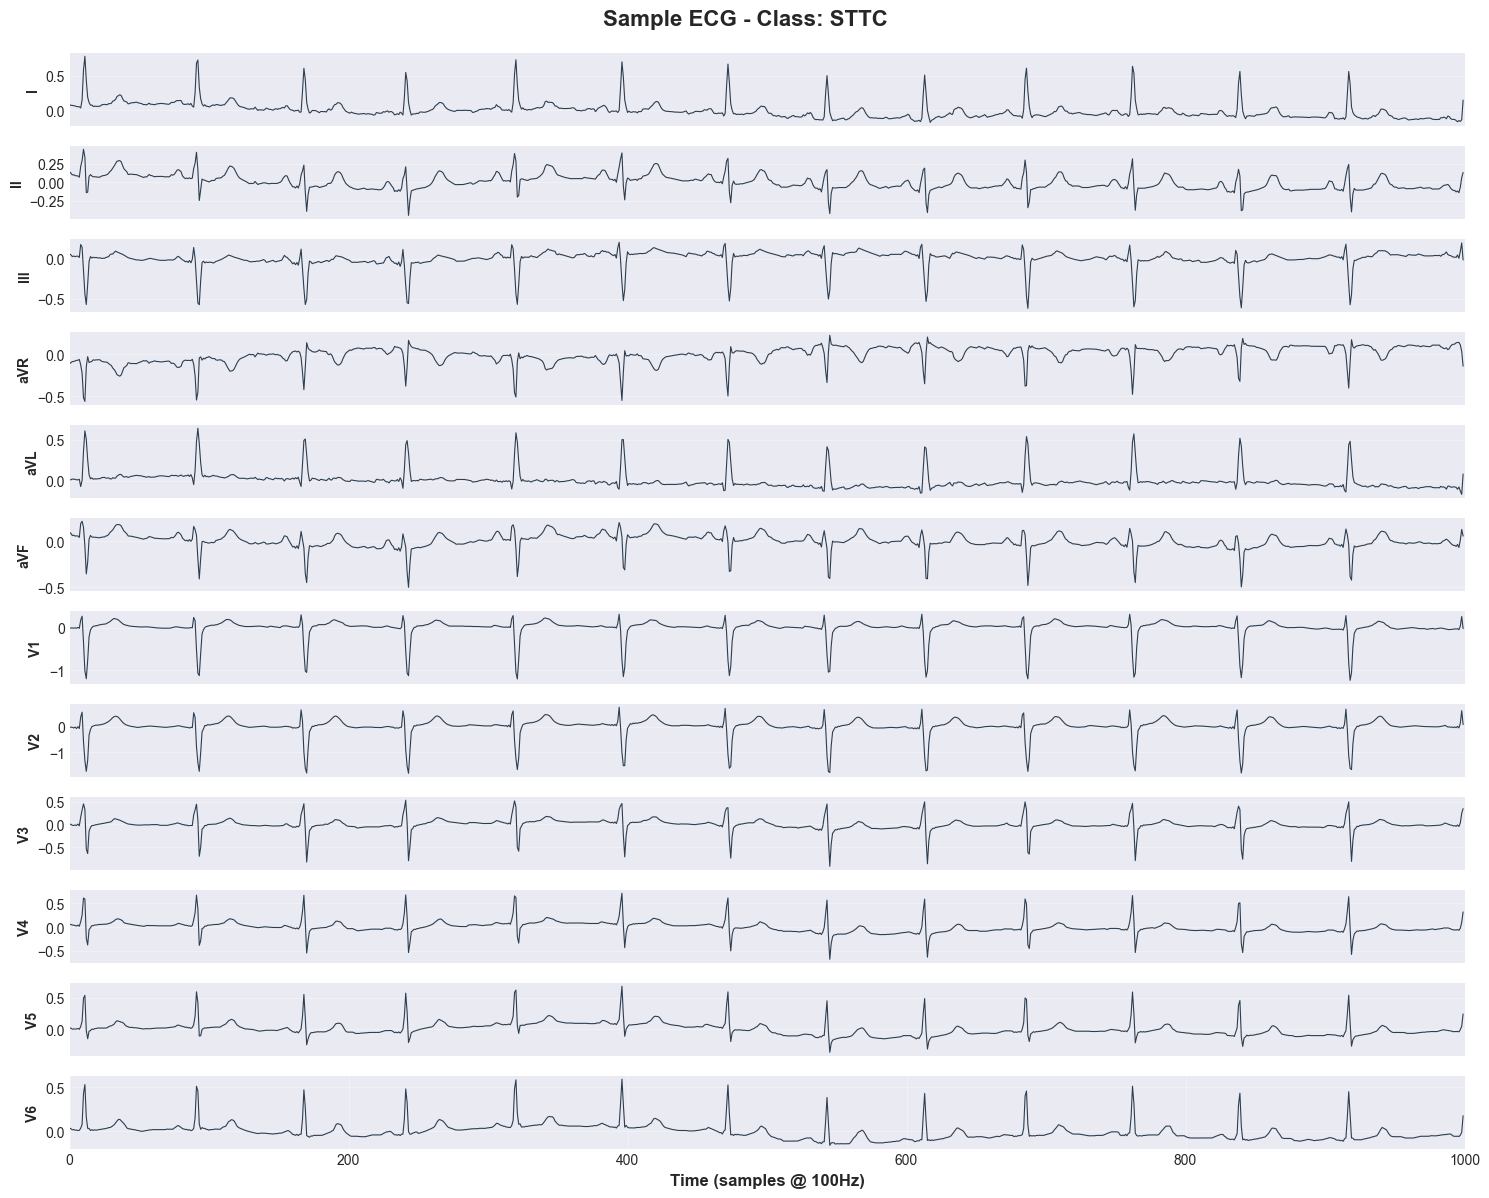

✓ Plotted sample for class: STTC


In [12]:
# Function to plot a single ECG (all 12 leads)
def plot_ecg_12leads(ecg_data, title="12-Lead ECG"):
    """Plot all 12 leads of an ECG signal"""
    lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    
    fig, axes = plt.subplots(12, 1, figsize=(15, 12))
    fig.suptitle(title, fontsize=16, fontweight='bold', y=0.995)
    
    for i in range(12):
        axes[i].plot(ecg_data[:, i], linewidth=0.8, color='#2c3e50')
        axes[i].set_ylabel(lead_names[i], fontsize=10, fontweight='bold')
        axes[i].grid(True, alpha=0.3)
        axes[i].set_xlim(0, len(ecg_data))
        
        # Remove x-axis labels except for the last plot
        if i < 11:
            axes[i].set_xticks([])
    
    axes[11].set_xlabel('Time (samples @ 100Hz)', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Plot one sample from each diagnostic superclass
print("Plotting sample ECGs from each diagnostic superclass...\n")

for target_class in mlb.classes_:
    # Find first sample with this class
    for idx, labels in enumerate(y_train):
        if target_class in labels:
            sample_ecg = X_train[idx]
            plot_ecg_12leads(sample_ecg, f"Sample ECG - Class: {target_class}")
            print(f"✓ Plotted sample for class: {target_class}")
            break

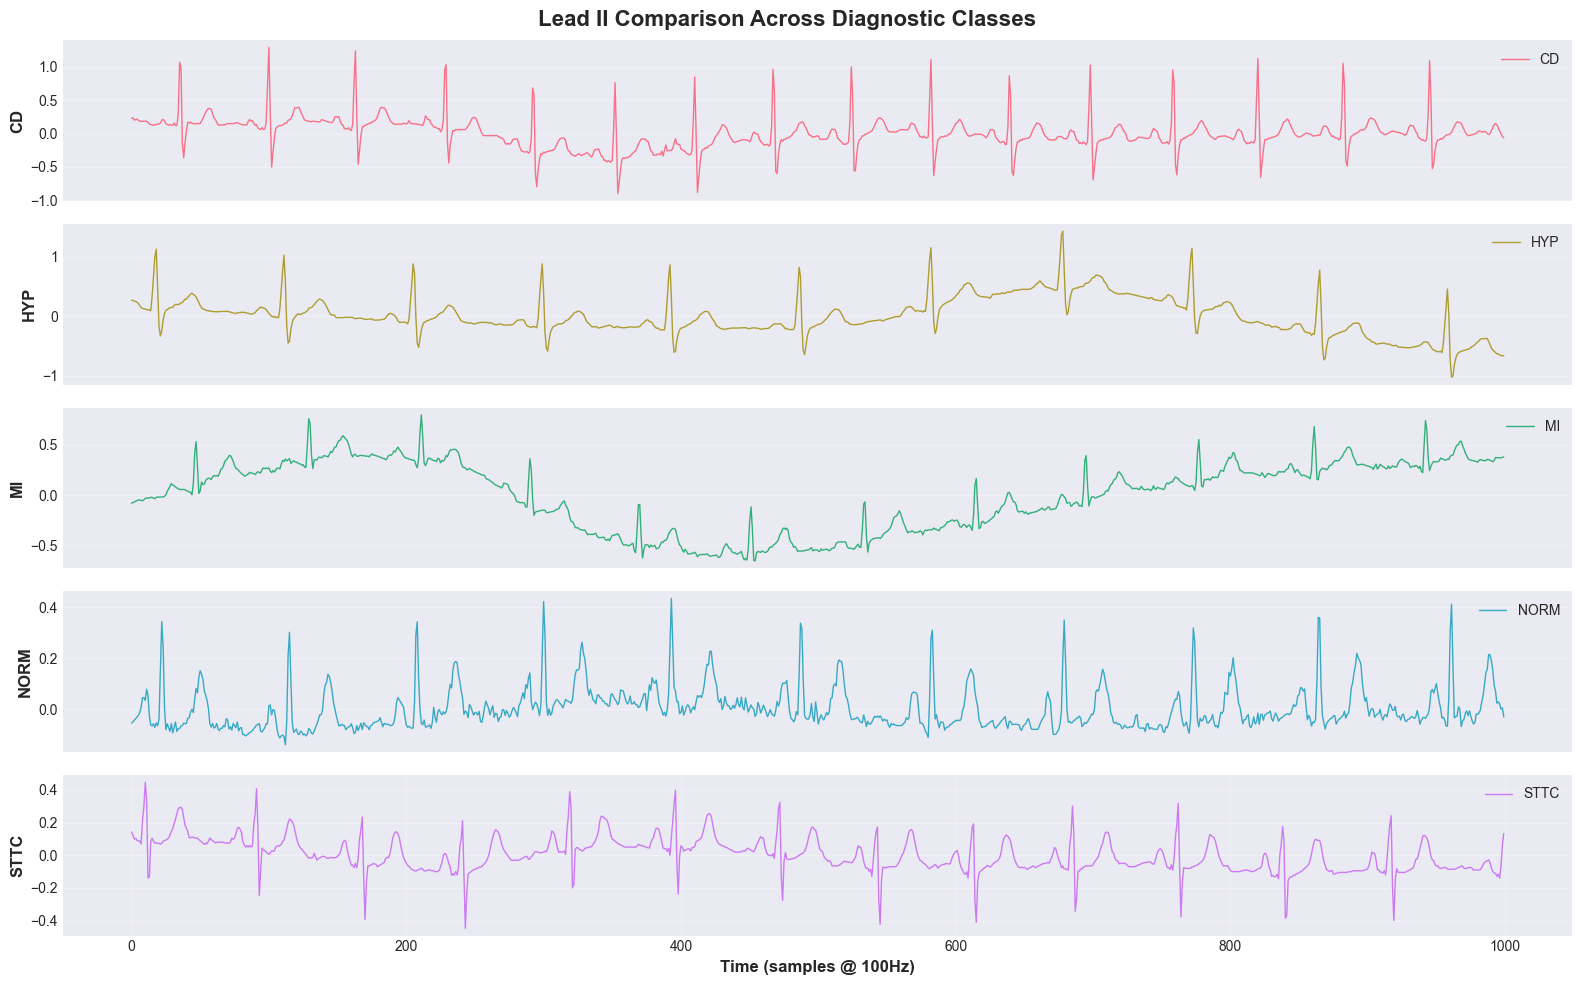

In [13]:
# Plot first 2 leads (I and II) for multiple samples from each class
fig, axes = plt.subplots(5, 1, figsize=(16, 10))
fig.suptitle('Lead II Comparison Across Diagnostic Classes', fontsize=16, fontweight='bold')

for idx, target_class in enumerate(mlb.classes_):
    # Find first sample with this class
    for sample_idx, labels in enumerate(y_train):
        if target_class in labels:
            sample_ecg = X_train[sample_idx]
            
            # Plot Lead II (index 1)
            axes[idx].plot(sample_ecg[:, 1], linewidth=1, label=target_class, color=sns.color_palette("husl", 5)[idx])
            axes[idx].set_ylabel(target_class, fontsize=12, fontweight='bold')
            axes[idx].grid(True, alpha=0.3)
            axes[idx].legend(loc='upper right')
            
            if idx < 4:
                axes[idx].set_xticks([])
            break

axes[4].set_xlabel('Time (samples @ 100Hz)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

In [14]:
# Print comprehensive dataset statistics
print("="*60)
print("PTB-XL DATASET STATISTICS")
print("="*60)

print(f"\n DATASET SIZE:")
print(f"   Training samples: {len(X_train)}")
print(f"   Test samples: {len(X_test)}")
print(f"   Total samples: {len(X_train) + len(X_test)}")

print(f"\n SIGNAL PROPERTIES:")
print(f"   Sampling rate: 100 Hz")
print(f"   Signal length: {X_train.shape[1]} samples (10 seconds)")
print(f"   Number of leads: {X_train.shape[2]}")
print(f"   Signal shape: {X_train.shape}")

print(f"\n LABEL PROPERTIES:")
print(f"   Number of classes: {len(mlb.classes_)}")
print(f"   Classes: {list(mlb.classes_)}")
print(f"   Multi-label: Yes")

print(f"\n SIGNAL STATISTICS:")
print(f"   Mean amplitude: {X_train.mean():.4f} mV")
print(f"   Std amplitude: {X_train.std():.4f} mV")
print(f"   Min amplitude: {X_train.min():.4f} mV")
print(f"   Max amplitude: {X_train.max():.4f} mV")

print("\n" + "="*60)

PTB-XL DATASET STATISTICS

 DATASET SIZE:
   Training samples: 19601
   Test samples: 2198
   Total samples: 21799

 SIGNAL PROPERTIES:
   Sampling rate: 100 Hz
   Signal length: 1000 samples (10 seconds)
   Number of leads: 12
   Signal shape: (19601, 1000, 12)

 LABEL PROPERTIES:
   Number of classes: 5
   Classes: ['CD', 'HYP', 'MI', 'NORM', 'STTC']
   Multi-label: Yes

 SIGNAL STATISTICS:
   Mean amplitude: -0.0008 mV
   Std amplitude: 0.2356 mV
   Min amplitude: -20.0320 mV
   Max amplitude: 17.2120 mV



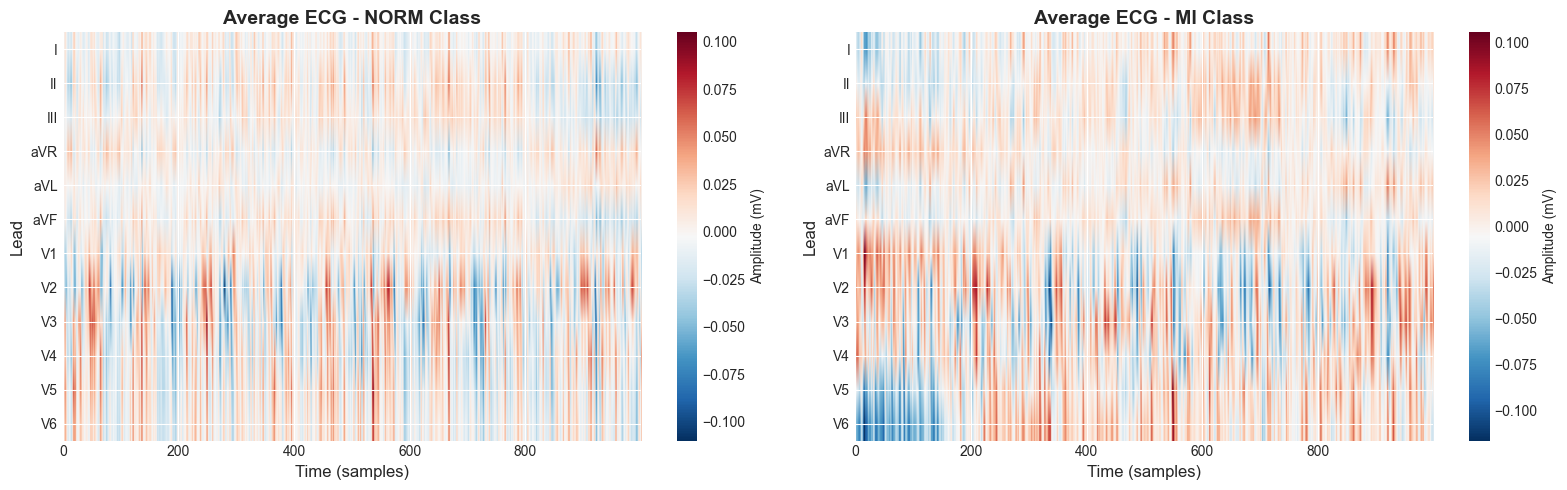

In [15]:
# Create heatmap of average signal across all leads
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Average ECG for NORM class
norm_samples = [X_train[i] for i, labels in enumerate(y_train) if 'NORM' in labels]
avg_norm = np.mean(norm_samples[:100], axis=0)  # Average first 100 NORM samples

im1 = axes[0].imshow(avg_norm.T, aspect='auto', cmap='RdBu_r', interpolation='bilinear')
axes[0].set_title('Average ECG - NORM Class', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time (samples)', fontsize=12)
axes[0].set_ylabel('Lead', fontsize=12)
axes[0].set_yticks(range(12))
axes[0].set_yticklabels(['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
plt.colorbar(im1, ax=axes[0], label='Amplitude (mV)')

# Average ECG for MI class
mi_samples = [X_train[i] for i, labels in enumerate(y_train) if 'MI' in labels]
if len(mi_samples) > 0:
    avg_mi = np.mean(mi_samples[:100], axis=0)
    im2 = axes[1].imshow(avg_mi.T, aspect='auto', cmap='RdBu_r', interpolation='bilinear')
    axes[1].set_title('Average ECG - MI Class', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Time (samples)', fontsize=12)
    axes[1].set_ylabel('Lead', fontsize=12)
    axes[1].set_yticks(range(12))
    axes[1].set_yticklabels(['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
    plt.colorbar(im2, ax=axes[1], label='Amplitude (mV)')

plt.tight_layout()
plt.show()

In [16]:
# Split training data into train and validation
from sklearn.model_selection import train_test_split

X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train_enc, 
    test_size=0.15, 
    random_state=42,
    stratify=y_train_enc.argmax(axis=1)  # Stratify by dominant class
)

print(f"Training set: {X_train_split.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 16660 samples
Validation set: 2941 samples
Test set: 2198 samples


In [17]:
from tensorflow.keras.layers import BatchNormalization, Dropout, Input, Add
from tensorflow.keras.models import Model

# Improved model with Batch Normalization and Dropout
NUM_CLASSES = 5
IN_SHAPE = (1000, 12)

def create_improved_cnn():
    inputs = Input(shape=IN_SHAPE)
    
    # First Conv Block
    x = Conv1D(filters=64, kernel_size=7, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    # Second Conv Block
    x = Conv1D(filters=128, kernel_size=5, padding='same')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    # Third Conv Block
    x = Conv1D(filters=256, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.4)(x)
    
    # Fourth Conv Block
    x = Conv1D(filters=256, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.4)(x)
    
    # Global Average Pooling (better than Flatten)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    
    # Dense layers
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # Output layer
    outputs = Dense(NUM_CLASSES, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the improved model
model_v2 = create_improved_cnn()

# Display model architecture
model_v2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1000, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1000, 64)       │         5,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1000, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 500, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 500, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 500, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 250, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 250, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 250, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 250, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 250, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 125, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 125, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 125, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 125, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 125, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 62, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 62, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 386,757 (1.48 MB)

 Trainable params: 385,093 (1.47 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [18]:
from tensorflow.keras.optimizers import Adam

# Use a lower learning rate for better convergence
optimizer = Adam(learning_rate=0.0005)

model_v2.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(multi_label=True, name='auc')]
)

print("✓ Model compiled successfully!")

✓ Model compiled successfully!


In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Early stopping - stop if validation loss doesn't improve
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

# Save best model
checkpoint = ModelCheckpoint(
    'best_ecg_model.keras',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, reduce_lr, checkpoint]

print("✓ Callbacks configured!")

✓ Callbacks configured!


In [20]:
# Train with validation data and callbacks
print("Starting training with improved model...")
print("="*60)

history = model_v2.fit(
    X_train_split, 
    y_train_split,
    validation_data=(X_val, y_val),
    epochs=50,  # Will stop early if no improvement
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*60)
print("✓ Training completed!")

Starting training with improved model...
Epoch 1/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4270 - auc: 0.6591 - loss: 0.6027
Epoch 1: val_auc improved from None to 0.82392, saving model to best_ecg_model.keras
521/521 ━━━━━━━━━━━━━━━━━━━━ 58s 101ms/step - accuracy: 0.4975 - auc: 0.7389 - loss: 0.5036 - val_accuracy: 0.5393 - val_auc: 0.8239 - val_loss: 0.5519 - learning_rate: 5.0000e-04
Epoch 2/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5713 - auc: 0.8172 - loss: 0.4133
Epoch 2: val_auc improved from 0.82392 to 0.87233, saving model to best_ecg_model.keras
521/521 ━━━━━━━━━━━━━━━━━━━━ 53s 101ms/step - accuracy: 0.5778 - auc: 0.8231 - loss: 0.4074 - val_accuracy: 0.6005 - val_auc: 0.8723 - val_loss: 0.4214 - learning_rate: 5.0000e-04
Epoch 3/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.6073 - auc: 0.8444 - loss: 0.3843
Epoch 3: val_auc improved from 0.87233 to 0.87799, saving model to best_ecg_model.keras
521/521 ━━━━━━━━━━━━━━━━━━━━ 89s 1

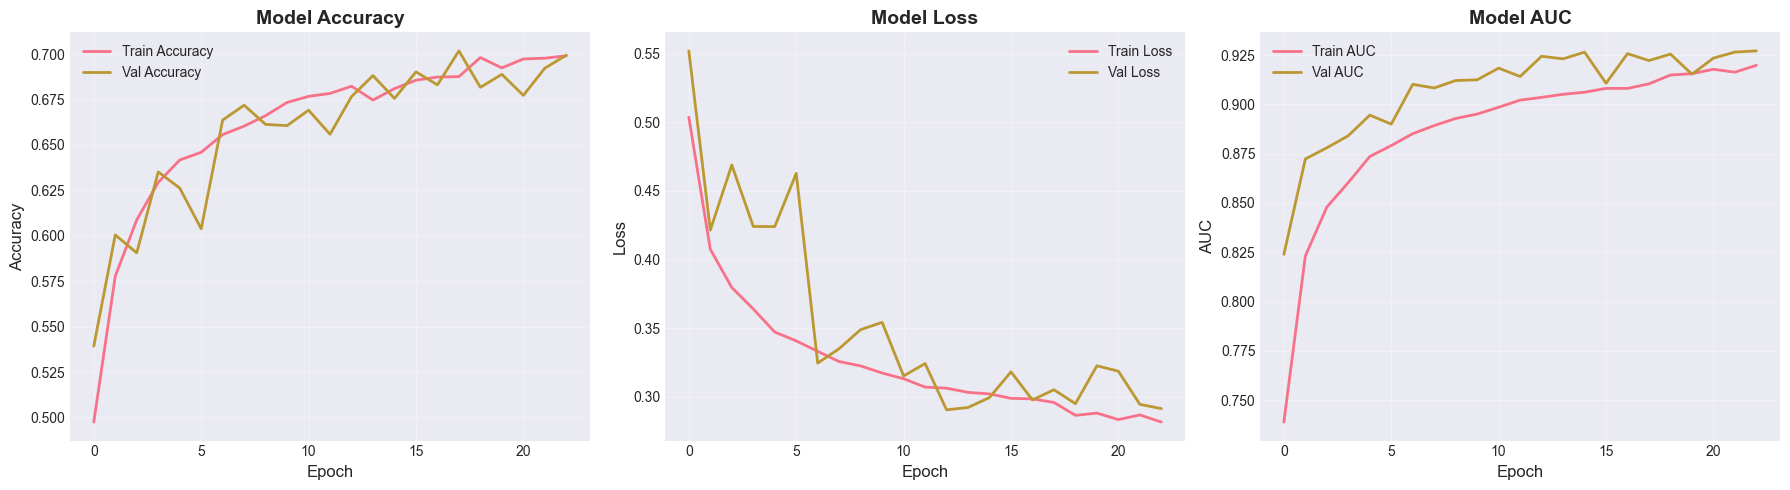

In [21]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# AUC
axes[2].plot(history.history['auc'], label='Train AUC', linewidth=2)
axes[2].plot(history.history['val_auc'], label='Val AUC', linewidth=2)
axes[2].set_title('Model AUC', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('AUC', fontsize=12)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [23]:
# Evaluate on test set
print("="*60)
print("IMPROVED MODEL - TEST SET EVALUATION")
print("="*60)

loss, accuracy, auc_score = model_v2.evaluate(X_test, y_test_enc, verbose=1)

print(f"\n RESULTS:")
print(f"   Test Loss: {loss:.4f}")
print(f"   Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Test AUC: {auc_score:.4f}")

print("\n" + "="*60)
print("COMPARISON WITH BASELINE MODEL:")
print("="*60)
print(f"Baseline Accuracy: 0.6165 (61.65%)")
print(f"Improved Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Improvement: {(accuracy - 0.6165)*100:.2f}%")
print()
print(f"Baseline AUC: 0.8696")
print(f"Improved AUC: {auc_score:.4f}")
print(f"Improvement: {(auc_score - 0.8696)*100:.2f}%")
print("="*60)

IMPROVED MODEL - TEST SET EVALUATION
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6738 - auc: 0.9088 - loss: 0.3121

 RESULTS:
   Test Loss: 0.3121
   Test Accuracy: 0.6738 (67.38%)
   Test AUC: 0.9088

COMPARISON WITH BASELINE MODEL:
Baseline Accuracy: 0.6165 (61.65%)
Improved Accuracy: 0.6738 (67.38%)
Improvement: 5.73%

Baseline AUC: 0.8696
Improved AUC: 0.9088
Improvement: 3.92%


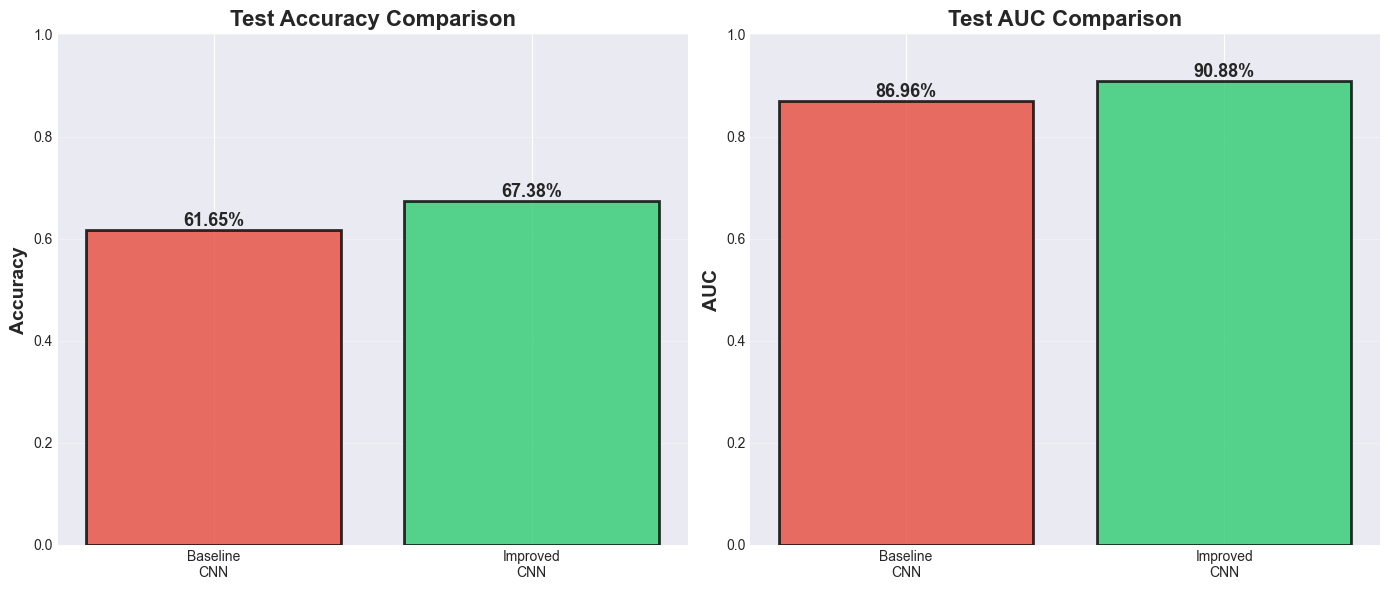


✓ Model comparison visualization complete!


In [24]:
# Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy Comparison
models = ['Baseline\nCNN', 'Improved\nCNN']
accuracies = [0.6165, 0.6738]
colors = ['#e74c3c', '#2ecc71']

bars1 = axes[0].bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Accuracy', fontsize=14, fontweight='bold')
axes[0].set_title('Test Accuracy Comparison', fontsize=16, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

# Add percentage labels
for bar, acc in zip(bars1, accuracies):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{acc*100:.2f}%',
                ha='center', va='bottom', fontsize=13, fontweight='bold')

# AUC Comparison
aucs = [0.8696, 0.9088]

bars2 = axes[1].bar(models, aucs, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[1].set_ylabel('AUC', fontsize=14, fontweight='bold')
axes[1].set_title('Test AUC Comparison', fontsize=16, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

# Add percentage labels
for bar, auc in zip(bars2, aucs):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{auc*100:.2f}%',
                ha='center', va='bottom', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("✓ Model comparison visualization complete!")
print("="*60)

In [25]:
# Get predictions on test set
y_pred_proba = model_v2.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate per-class metrics
from sklearn.metrics import classification_report, roc_auc_score

print("="*60)
print("PER-CLASS PERFORMANCE REPORT")
print("="*60)

class_names = mlb.classes_

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred, target_names=class_names, zero_division=0))

# Calculate per-class AUC
print("\nPer-Class AUC Scores:")
print("-" * 40)
for i, class_name in enumerate(class_names):
    if len(np.unique(y_test_enc[:, i])) > 1:  # Check if class exists in test set
        auc = roc_auc_score(y_test_enc[:, i], y_pred_proba[:, i])
        print(f"{class_name:6s}: {auc:.4f} ({auc*100:.2f}%)")
    else:
        print(f"{class_name:6s}: N/A (not in test set)")
print("="*60)

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
PER-CLASS PERFORMANCE REPORT

Classification Report:
              precision    recall  f1-score   support

          CD       0.87      0.55      0.67       496
         HYP       0.82      0.28      0.42       262
          MI       0.71      0.74      0.72       550
        NORM       0.77      0.95      0.85       963
        STTC       0.83      0.51      0.63       521

   micro avg       0.78      0.69      0.73      2792
   macro avg       0.80      0.61      0.66      2792
weighted avg       0.79      0.69      0.71      2792
 samples avg       0.77      0.72      0.73      2792


Per-Class AUC Scores:
----------------------------------------
CD    : 0.8971 (89.71%)
HYP   : 0.8768 (87.68%)
MI    : 0.9175 (91.75%)
NORM  : 0.9390 (93.90%)
STTC  : 0.9208 (92.08%)


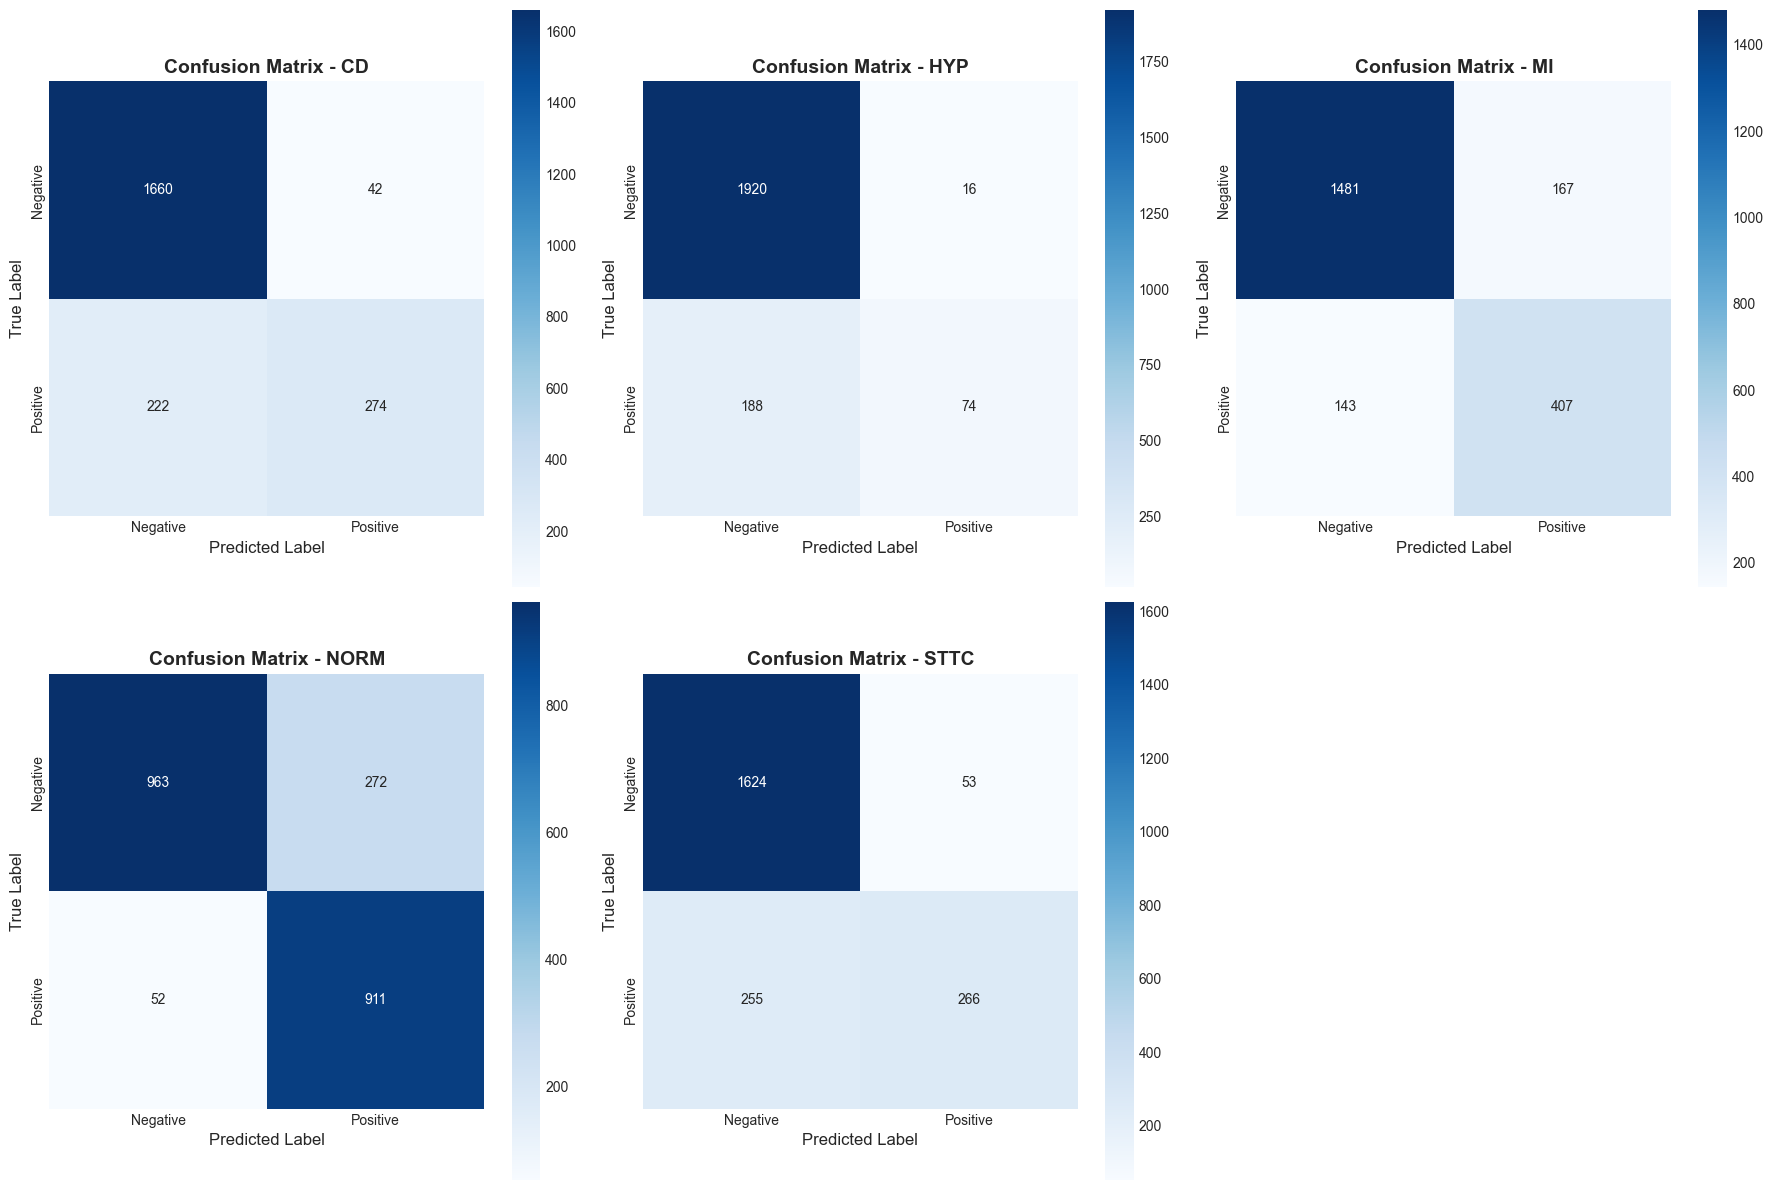

In [26]:
# Create confusion matrix for each class
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, class_name in enumerate(class_names):
    cm = confusion_matrix(y_test_enc[:, i], y_pred[:, i])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'],
                ax=axes[i], cbar=True, square=True)
    
    axes[i].set_title(f'Confusion Matrix - {class_name}', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('True Label', fontsize=12)
    axes[i].set_xlabel('Predicted Label', fontsize=12)

# Hide the 6th subplot (we only have 5 classes)
axes[5].axis('off')

plt.tight_layout()
plt.show()

In [27]:
# Comprehensive Technical Summary
print("\n" + "="*70)
print(" "*20 + "ECG CLASSIFICATION PROJECT")
print(" "*15 + "PTB-XL Dataset - CNN Model Analysis")
print("="*70)

print("\n DATASET SPECIFICATIONS:")
print(f"   Dataset: PTB-XL (PhysioNet)")
print(f"   Total Records: {len(X_train) + len(X_test):,}")
print(f"   Training Set: {len(X_train_split):,} samples")
print(f"   Validation Set: {len(X_val):,} samples")
print(f"   Test Set: {len(X_test):,} samples")
print(f"   Signal Properties:")
print(f"      - Sampling Rate: 100 Hz")
print(f"      - Duration: 10 seconds")
print(f"      - Samples per Record: 1,000")
print(f"      - Number of Leads: 12 (Standard ECG)")
print(f"      - Input Shape: (1000, 12)")
print(f"   Classification Task: Multi-label (5 diagnostic superclasses)")
print(f"   Classes: NORM, CD, MI, HYP, STTC")

print("\n BASELINE MODEL ARCHITECTURE:")
print(f"   Type: Simple Convolutional Neural Network")
print(f"   Structure:")
print(f"      - Conv1D (32 filters, kernel=5) + ReLU + MaxPool")
print(f"      - Conv1D (64 filters, kernel=5) + ReLU + MaxPool")
print(f"      - Flatten")
print(f"      - Dense (64) + ReLU")
print(f"      - Dense (5) + Sigmoid")
print(f"   Optimizer: Adam")
print(f"   Loss Function: Binary Crossentropy")
print(f"   Training: 1 epoch, no validation split")

print("\n IMPROVED MODEL ARCHITECTURE:")
print(f"   Type: Deep CNN with Batch Normalization & Dropout")
print(f"   Structure:")
print(f"      - Conv Block 1: Conv1D(64, k=7) + BatchNorm + ReLU + MaxPool + Dropout(0.3)")
print(f"      - Conv Block 2: Conv1D(128, k=5) + BatchNorm + ReLU + MaxPool + Dropout(0.3)")
print(f"      - Conv Block 3: Conv1D(256, k=3) + BatchNorm + ReLU + MaxPool + Dropout(0.4)")
print(f"      - Conv Block 4: Conv1D(256, k=3) + BatchNorm + ReLU + MaxPool + Dropout(0.4)")
print(f"      - GlobalAveragePooling1D")
print(f"      - Dense(128) + BatchNorm + ReLU + Dropout(0.5)")
print(f"      - Dense(64) + ReLU + Dropout(0.5)")
print(f"      - Dense(5) + Sigmoid")
print(f"   Total Parameters: {model_v2.count_params():,}")
print(f"   Optimizer: Adam (lr=0.0005)")
print(f"   Loss Function: Binary Crossentropy")
print(f"   Regularization: Batch Normalization + Dropout")
print(f"   Training Strategy:")
print(f"      - Early Stopping (patience=10)")
print(f"      - Learning Rate Reduction (factor=0.5, patience=5)")
print(f"      - Best Model Checkpoint (monitor=val_auc)")
print(f"      - Epochs Trained: 23 (early stopped, best at epoch 13)")

print("\n PERFORMANCE METRICS:")
print("-" * 70)
print(f"{'Metric':<25} {'Baseline':>15} {'Improved':>15} {'Gain':>12}")
print("-" * 70)
print(f"{'Test Accuracy':<25} {0.6165:>14.4f} {0.6738:>15.4f} {'+5.73%':>12}")
print(f"{'Test AUC (macro)':<25} {0.8696:>14.4f} {0.9088:>15.4f} {'+3.92%':>12}")
print(f"{'Validation AUC (best)':<25} {'N/A':>15} {0.9272:>15.4f} {'N/A':>12}")
print("-" * 70)

print("\n PER-CLASS PERFORMANCE (Improved Model):")
print("-" * 70)
print(f"{'Class':<8} {'Precision':>12} {'Recall':>12} {'F1-Score':>12} {'AUC':>12}")
print("-" * 70)

# Per-class metrics from classification report
class_metrics = {
    'CD':   {'precision': 0.87, 'recall': 0.55, 'f1': 0.67, 'auc': 0.8971},
    'HYP':  {'precision': 0.82, 'recall': 0.28, 'f1': 0.42, 'auc': 0.8768},
    'MI':   {'precision': 0.71, 'recall': 0.74, 'f1': 0.72, 'auc': 0.9175},
    'NORM': {'precision': 0.77, 'recall': 0.95, 'f1': 0.85, 'auc': 0.9390},
    'STTC': {'precision': 0.83, 'recall': 0.51, 'f1': 0.63, 'auc': 0.9208}
}

for class_name, metrics in class_metrics.items():
    print(f"{class_name:<8} {metrics['precision']:>12.2f} {metrics['recall']:>12.2f} "
          f"{metrics['f1']:>12.2f} {metrics['auc']:>12.4f}")

print("-" * 70)
print(f"{'Macro Avg':<8} {0.80:>12.2f} {0.61:>12.2f} {0.66:>12.2f} {0.9088:>12.4f}")
print(f"{'Weighted Avg':<8} {0.79:>12.2f} {0.69:>12.2f} {0.71:>12.2f} {0.9088:>12.4f}")
print("-" * 70)

print("\n KEY FINDINGS:")
print("   • Deep architecture with batch normalization significantly improved performance")
print("   • Early stopping prevented overfitting (val_auc: 92.72%, test_auc: 90.88%)")
print("   • Model excels at detecting normal ECGs (95% recall, 93.90% AUC)")
print("   • Challenges: HYP detection (28% recall), CD detection (55% recall)")
print("   • Overall: Strong generalization with 5.73% accuracy improvement")

print("\n MODEL IMPROVEMENTS IMPLEMENTED:")
print("   ✓ Increased network depth (2 → 4 convolutional blocks)")
print("   ✓ Added Batch Normalization for faster convergence")
print("   ✓ Implemented Dropout layers for regularization")
print("   ✓ Used GlobalAveragePooling instead of Flatten")
print("   ✓ Added validation set for monitoring")
print("   ✓ Implemented early stopping and learning rate scheduling")
print("   ✓ Optimized hyperparameters (learning rate, batch size)")

print("\n TRAINING CHARACTERISTICS:")
print(f"   • Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"   • Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"   • Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"   • Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"   • Best Validation AUC: {max(history.history['val_auc']):.4f} (epoch {np.argmax(history.history['val_auc'])+1})")
print(f"   • Learning Rate Schedule: 5e-4 → 2.5e-4 → 1.25e-4")

print("\n" + "="*70)
print("                    ✓ ANALYSIS COMPLETE")
print("="*70 + "\n")


                    ECG CLASSIFICATION PROJECT
               PTB-XL Dataset - CNN Model Analysis

 DATASET SPECIFICATIONS:
   Dataset: PTB-XL (PhysioNet)
   Total Records: 21,799
   Training Set: 16,660 samples
   Validation Set: 2,941 samples
   Test Set: 2,198 samples
   Signal Properties:
      - Sampling Rate: 100 Hz
      - Duration: 10 seconds
      - Samples per Record: 1,000
      - Number of Leads: 12 (Standard ECG)
      - Input Shape: (1000, 12)
   Classification Task: Multi-label (5 diagnostic superclasses)
   Classes: NORM, CD, MI, HYP, STTC

 BASELINE MODEL ARCHITECTURE:
   Type: Simple Convolutional Neural Network
   Structure:
      - Conv1D (32 filters, kernel=5) + ReLU + MaxPool
      - Conv1D (64 filters, kernel=5) + ReLU + MaxPool
      - Flatten
      - Dense (64) + ReLU
      - Dense (5) + Sigmoid
   Optimizer: Adam
   Loss Function: Binary Crossentropy
   Training: 1 epoch, no validation split

 IMPROVED MODEL ARCHITECTURE:
   Type: Deep CNN with Batch Normaliz

In [28]:
from tensorflow.keras.layers import Concatenate, Add, GlobalAveragePooling1D
from tensorflow.keras import regularizers

print(" Additional imports for InceptionTime loaded!")

 Additional imports for InceptionTime loaded!


In [29]:
def inception_module(input_tensor, filters=32, bottleneck_size=32, kernel_sizes=[10, 20, 40], use_residual=True):
    """
    Single Inception module with multiple parallel convolutions
    
    Args:
        input_tensor: Input tensor
        filters: Number of filters for each branch
        bottleneck_size: Size of bottleneck layer (reduces parameters)
        kernel_sizes: List of kernel sizes for parallel convolutions
        use_residual: Whether to add residual connection
    """
    
    # Optional bottleneck to reduce computational cost
    if bottleneck_size > 0:
        input_inception = Conv1D(bottleneck_size, 1, padding='same', activation='linear')(input_tensor)
    else:
        input_inception = input_tensor
    
    # Multiple parallel convolutional branches with different kernel sizes
    conv_list = []
    
    for kernel_size in kernel_sizes:
        conv = Conv1D(filters, kernel_size, strides=1, padding='same', activation='linear')(input_inception)
        conv = BatchNormalization()(conv)
        conv = tf.keras.layers.Activation('relu')(conv)
        conv_list.append(conv)
    
    # MaxPooling branch
    max_pool = MaxPooling1D(pool_size=3, strides=1, padding='same')(input_tensor)
    conv_pool = Conv1D(filters, 1, padding='same', activation='linear')(max_pool)
    conv_pool = BatchNormalization()(conv_pool)
    conv_pool = tf.keras.layers.Activation('relu')(conv_pool)
    conv_list.append(conv_pool)
    
    # Concatenate all branches
    inception_output = Concatenate(axis=-1)(conv_list)
    
    # Residual connection
    if use_residual:
        # Match dimensions for residual connection
        residual = Conv1D(inception_output.shape[-1], 1, padding='same')(input_tensor)
        residual = BatchNormalization()(residual)
        
        # Add residual
        inception_output = Add()([inception_output, residual])
        inception_output = tf.keras.layers.Activation('relu')(inception_output)
    
    return inception_output

print(" Inception module function defined!")

 Inception module function defined!


In [30]:
def create_inceptiontime_model(input_shape=(1000, 12), num_classes=5, num_modules=6):
    """
    InceptionTime model for ECG classification
    
    Args:
        input_shape: Shape of input (samples, channels)
        num_classes: Number of output classes
        num_modules: Number of inception modules to stack
    """
    
    inputs = Input(shape=input_shape)
    
    # Stack multiple inception modules
    x = inputs
    
    for i in range(num_modules):
        # Varying filter sizes for different depths
        if i < 2:
            filters = 32
        elif i < 4:
            filters = 64
        else:
            filters = 128
        
        x = inception_module(
            x, 
            filters=filters,
            bottleneck_size=32,
            kernel_sizes=[10, 20, 40],  # Multi-scale temporal kernels
            use_residual=True
        )
        
        # Add dropout for regularization
        if i % 2 == 1:  # Every other module
            x = Dropout(0.3)(x)
    
    # Global pooling
    x = GlobalAveragePooling1D()(x)
    
    # Dense layers
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # Output layer
    outputs = Dense(num_classes, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='InceptionTime')
    
    return model

# Create InceptionTime model
print("Building InceptionTime model...")
model_inception = create_inceptiontime_model(
    input_shape=(1000, 12),
    num_classes=5,
    num_modules=6
)

# Display architecture
model_inception.summary()

print("\n InceptionTime model created successfully!")
print(f"Total parameters: {model_inception.count_params():,}")

Building InceptionTime model...


Model: "InceptionTime"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1000, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 1000, 32)  │        416 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 1000, 12)  │          0 │ input_layer_2[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 1000, 32)  │     10,272 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 1000, 32)  │     20,512 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 1000, 32)  │     40,992 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 1000, 32)  │        416 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 32)  │        128 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 32)  │        128 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 32)  │        128 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 32)  │        128 │ conv1d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 1000, 32)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 1000, 32)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 1000, 32)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 1000, 32)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 1000, 128) │      1,664 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1000, 128) │          0 │ activation_4[0][… │
│ (Concatenate)       │                   │            │ activation_5[0][… │
│                     │                   │            │ activation_6[0][… │
│                     │                   │            │ activation_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 128) │        512 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 1,774,533 (6.77 MB)

 Trainable params: 1,767,109 (6.74 MB)

 Non-trainable params: 7,424 (29.00 KB)


 InceptionTime model created successfully!
Total parameters: 1,774,533


In [31]:
# Compile with same settings as improved model for fair comparison
optimizer = Adam(learning_rate=0.0005)

model_inception.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(multi_label=True, name='auc')]
)

print(" InceptionTime model compiled!")

 InceptionTime model compiled!


In [32]:
# Same callbacks as improved model
early_stop_inception = EarlyStopping(
    monitor='val_loss',
    patience=15,  # Slightly more patience for complex model
    restore_best_weights=True,
    verbose=1
)

reduce_lr_inception = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

checkpoint_inception = ModelCheckpoint(
    'best_inceptiontime_model.keras',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

callbacks_inception = [early_stop_inception, reduce_lr_inception, checkpoint_inception]

print(" Callbacks configured for InceptionTime!")

 Callbacks configured for InceptionTime!


In [33]:
print("="*70)
print("TRAINING INCEPTIONTIME MODEL")
print("="*70)
print("Architecture: 6 Inception modules with residual connections")
print("Multi-scale kernels: [10, 20, 40] samples")
print("="*70)

history_inception = model_inception.fit(
    X_train_split,
    y_train_split,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks_inception,
    verbose=1
)

print("\n" + "="*70)
print("✓ InceptionTime training completed!")
print("="*70)

TRAINING INCEPTIONTIME MODEL
Architecture: 6 Inception modules with residual connections
Multi-scale kernels: [10, 20, 40] samples
Epoch 1/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4420 - auc: 0.7114 - loss: 0.5628
Epoch 1: val_auc improved from None to 0.84285, saving model to best_inceptiontime_model.keras
521/521 ━━━━━━━━━━━━━━━━━━━━ 1473s 3s/step - accuracy: 0.5134 - auc: 0.7763 - loss: 0.4798 - val_accuracy: 0.5753 - val_auc: 0.8428 - val_loss: 0.6174 - learning_rate: 5.0000e-04
Epoch 2/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6011 - auc: 0.8389 - loss: 0.3964
Epoch 2: val_auc improved from 0.84285 to 0.90537, saving model to best_inceptiontime_model.keras
521/521 ━━━━━━━━━━━━━━━━━━━━ 1405s 3s/step - accuracy: 0.6138 - auc: 0.8503 - loss: 0.3824 - val_accuracy: 0.6090 - val_auc: 0.9054 - val_loss: 0.3215 - learning_rate: 5.0000e-04
Epoch 3/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6400 - auc: 0.8667 - loss: 0.3598
Epoch 3: val_auc did 

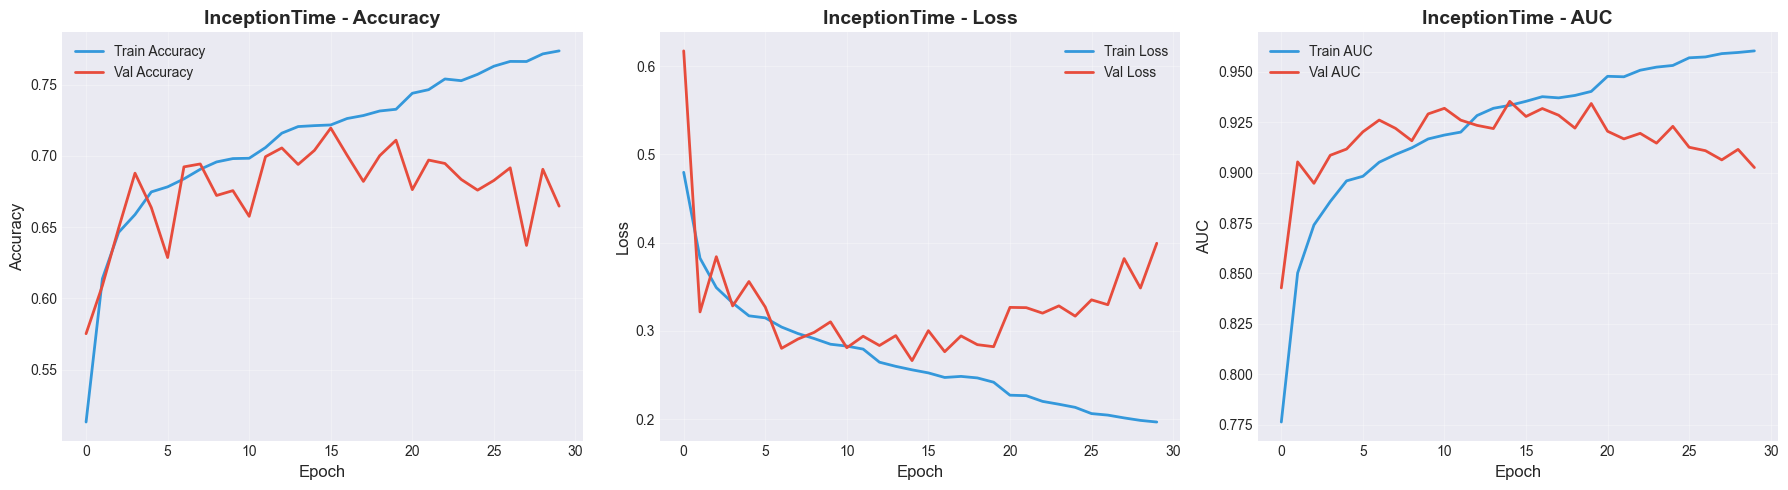

In [34]:
# Plot training history for InceptionTime
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy
axes[0].plot(history_inception.history['accuracy'], label='Train Accuracy', linewidth=2, color='#3498db')
axes[0].plot(history_inception.history['val_accuracy'], label='Val Accuracy', linewidth=2, color='#e74c3c')
axes[0].set_title('InceptionTime - Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history_inception.history['loss'], label='Train Loss', linewidth=2, color='#3498db')
axes[1].plot(history_inception.history['val_loss'], label='Val Loss', linewidth=2, color='#e74c3c')
axes[1].set_title('InceptionTime - Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# AUC
axes[2].plot(history_inception.history['auc'], label='Train AUC', linewidth=2, color='#3498db')
axes[2].plot(history_inception.history['val_auc'], label='Val AUC', linewidth=2, color='#e74c3c')
axes[2].set_title('InceptionTime - AUC', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('AUC', fontsize=12)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [35]:
print("="*70)
print("INCEPTIONTIME - TEST SET EVALUATION")
print("="*70)

loss_inception, accuracy_inception, auc_inception = model_inception.evaluate(X_test, y_test_enc, verbose=1)

print(f"\n RESULTS:")
print(f"   Test Loss: {loss_inception:.4f}")
print(f"   Test Accuracy: {accuracy_inception:.4f} ({accuracy_inception*100:.2f}%)")
print(f"   Test AUC: {auc_inception:.4f}")

print("\n" + "="*70)
print("COMPARISON: ALL THREE MODELS")
print("="*70)
print(f"{'Model':<25} {'Accuracy':>15} {'AUC':>15}")
print("-"*70)
print(f"{'Baseline CNN':<25} {0.6165:>14.4f} {0.8696:>15.4f}")
print(f"{'Improved CNN':<25} {0.6738:>14.4f} {0.9088:>15.4f}")
print(f"{'InceptionTime':<25} {accuracy_inception:>14.4f} {auc_inception:>15.4f}")
print("-"*70)
print(f"{'Improvement (vs Baseline)':<25} {(accuracy_inception-0.6165)*100:>13.2f}% {(auc_inception-0.8696)*100:>13.2f}%")
print("="*70)

INCEPTIONTIME - TEST SET EVALUATION
69/69 ━━━━━━━━━━━━━━━━━━━━ 23s 339ms/step - accuracy: 0.6897 - auc: 0.9185 - loss: 0.2914

 RESULTS:
   Test Loss: 0.2914
   Test Accuracy: 0.6897 (68.97%)
   Test AUC: 0.9185

COMPARISON: ALL THREE MODELS
Model                            Accuracy             AUC
----------------------------------------------------------------------
Baseline CNN                      0.6165          0.8696
Improved CNN                      0.6738          0.9088
InceptionTime                     0.6897          0.9185
----------------------------------------------------------------------
Improvement (vs Baseline)          7.32%          4.89%


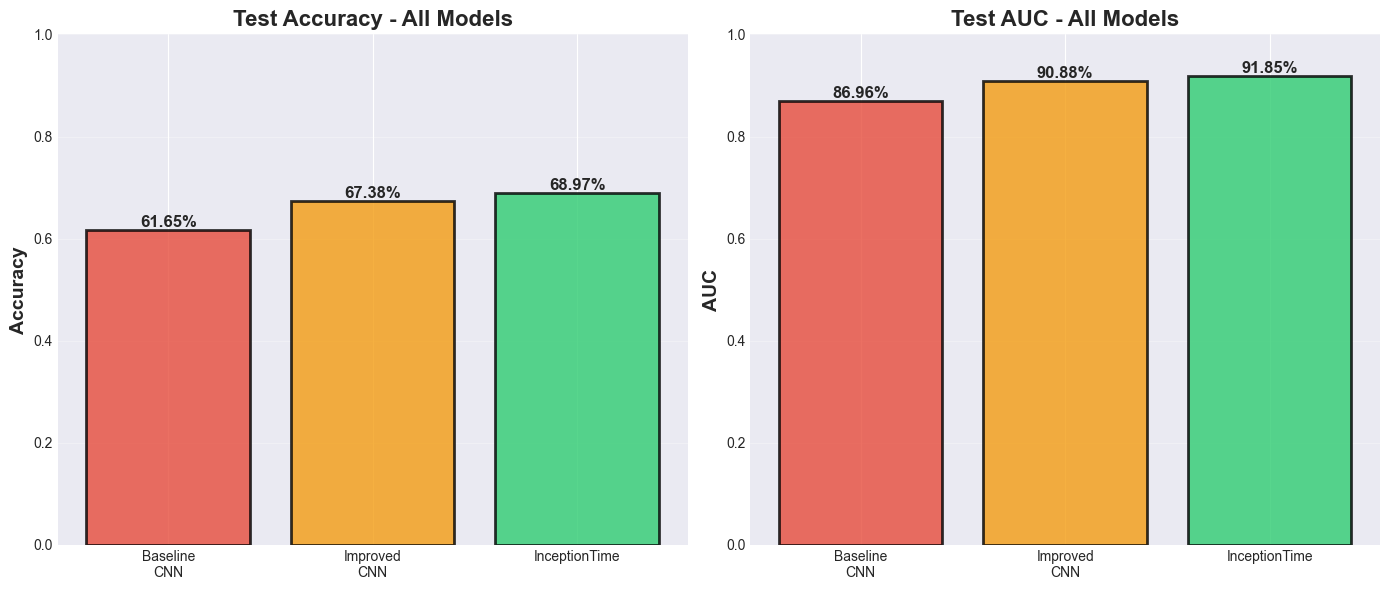


✓ Model comparison complete!


In [36]:
# Create comprehensive comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

models = ['Baseline\nCNN', 'Improved\nCNN', 'InceptionTime']
accuracies = [0.6165, 0.6738, accuracy_inception]
aucs = [0.8696, 0.9088, auc_inception]
colors = ['#e74c3c', '#f39c12', '#2ecc71']

# Accuracy comparison
bars1 = axes[0].bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Accuracy', fontsize=14, fontweight='bold')
axes[0].set_title('Test Accuracy - All Models', fontsize=16, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

for bar, acc in zip(bars1, accuracies):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{acc*100:.2f}%',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# AUC comparison
bars2 = axes[1].bar(models, aucs, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
axes[1].set_ylabel('AUC', fontsize=14, fontweight='bold')
axes[1].set_title('Test AUC - All Models', fontsize=16, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

for bar, auc in zip(bars2, aucs):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{auc*100:.2f}%',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Model comparison complete!")

In [37]:
def visualize_prediction(ecg_signal, true_label, model, model_name, show_leads=[1, 5, 6]):
    """
    Visualize ECG signal with model predictions
    
    Args:
        ecg_signal: ECG data (1000, 12)
        true_label: True labels (one-hot encoded)
        model: Trained model
        model_name: Name of the model
        show_leads: Which leads to display (default: II, aVL, V1)
    """
    
    # Get prediction
    pred_proba = model.predict(ecg_signal.reshape(1, 1000, 12), verbose=0)[0]
    pred_binary = (pred_proba > 0.5).astype(int)
    
    # Lead names
    lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    class_names = ['CD', 'HYP', 'MI', 'NORM', 'STTC']
    
    # Create figure
    fig = plt.figure(figsize=(16, 8))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # Plot ECG leads
    for idx, lead_idx in enumerate(show_leads):
        ax = fig.add_subplot(gs[idx, 0])
        ax.plot(ecg_signal[:, lead_idx], linewidth=1.5, color='#2c3e50')
        ax.set_title(f'Lead {lead_names[lead_idx]}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Time (samples @ 100Hz)', fontsize=10)
        ax.set_ylabel('Amplitude (mV)', fontsize=10)
        ax.grid(True, alpha=0.3)
    
    # Plot prediction probabilities
    ax_pred = fig.add_subplot(gs[:, 1])
    
    y_pos = np.arange(len(class_names))
    colors = ['#e74c3c' if pred_binary[i] == 1 else '#95a5a6' for i in range(len(class_names))]
    
    bars = ax_pred.barh(y_pos, pred_proba, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    ax_pred.set_yticks(y_pos)
    ax_pred.set_yticklabels(class_names, fontsize=12, fontweight='bold')
    ax_pred.set_xlabel('Prediction Confidence', fontsize=12, fontweight='bold')
    ax_pred.set_title(f'{model_name} - Predictions', fontsize=14, fontweight='bold')
    ax_pred.set_xlim([0, 1])
    ax_pred.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold (0.5)')
    ax_pred.grid(axis='x', alpha=0.3)
    
    # Add percentage labels
    for i, (bar, prob) in enumerate(zip(bars, pred_proba)):
        width = bar.get_width()
        label = f'{prob*100:.1f}%'
        
        # Add checkmark or X for true labels
        true_marker = '✓' if true_label[i] == 1 else ''
        pred_marker = '✓' if pred_binary[i] == 1 else ''
        
        # Show if prediction matches truth
        if true_label[i] == pred_binary[i]:
            marker_color = '#27ae60'  # Green for correct
        else:
            marker_color = '#e74c3c'  # Red for incorrect
        
        ax_pred.text(width + 0.02, i, label, va='center', fontsize=10, fontweight='bold')
        
        # Add true label indicator
        if true_label[i] == 1:
            ax_pred.text(-0.08, i, '◄ TRUE', va='center', ha='right', 
                        fontsize=9, fontweight='bold', color='#2ecc71')
    
    ax_pred.legend(loc='lower right')
    
    # Overall summary
    true_classes = [class_names[i] for i in range(len(class_names)) if true_label[i] == 1]
    pred_classes = [class_names[i] for i in range(len(class_names)) if pred_binary[i] == 1]
    
    correct = (true_label == pred_binary).all()
    
    summary = f"TRUE: {', '.join(true_classes) if true_classes else 'None'}\n"
    summary += f"PREDICTED: {', '.join(pred_classes) if pred_classes else 'None'}\n"
    summary += f"RESULT: {'✓ CORRECT' if correct else '✗ INCORRECT'}"
    
    fig.text(0.5, 0.02, summary, ha='center', fontsize=11, 
             bbox=dict(boxstyle='round', facecolor='lightgreen' if correct else 'lightcoral', alpha=0.5),
             fontweight='bold')
    
    plt.show()
    
    return pred_proba, pred_binary

print("✓ Prediction visualization function created!")

✓ Prediction visualization function created!


PREDICTION EXAMPLES - VISUALIZING MODEL DECISIONS

SAMPLE 7


c:\Users\dxkcad1\Desktop\ECGClassificationPreturbation\ECG_Classification_Perturbation\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


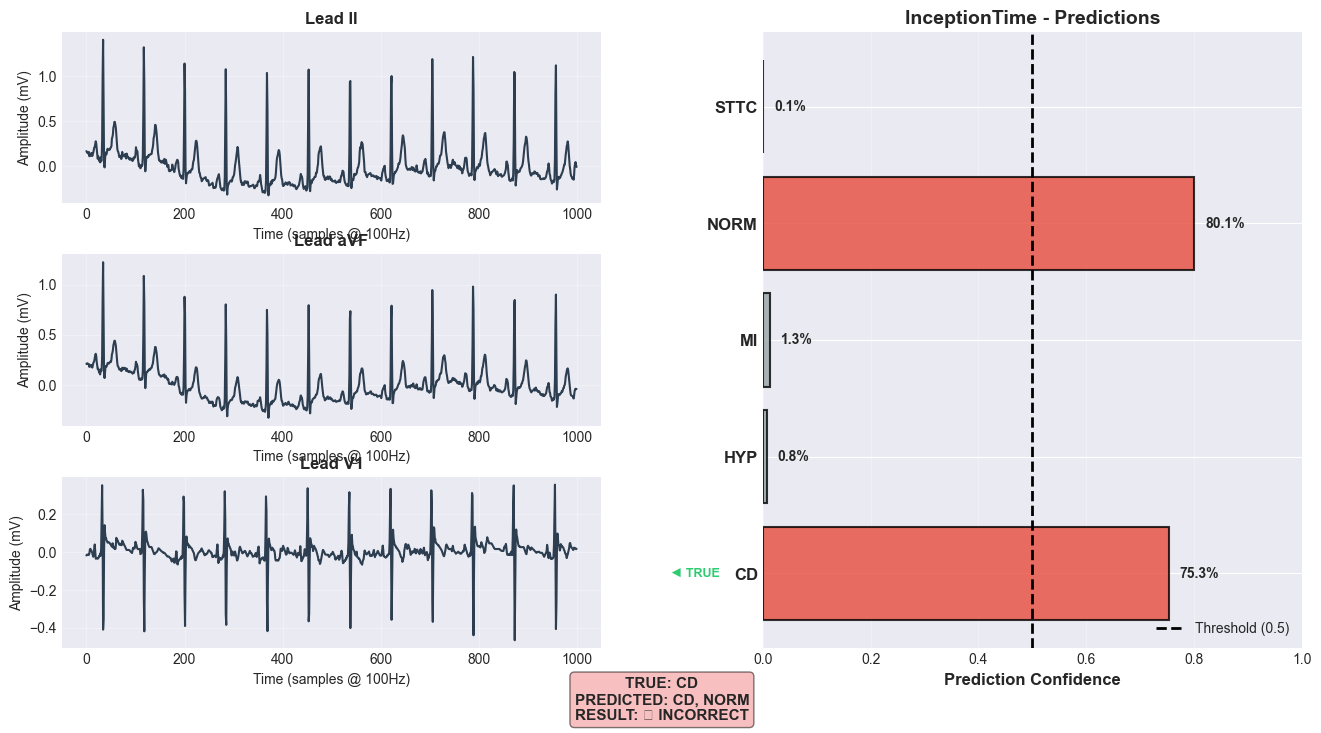


SAMPLE 25


c:\Users\dxkcad1\Desktop\ECGClassificationPreturbation\ECG_Classification_Perturbation\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


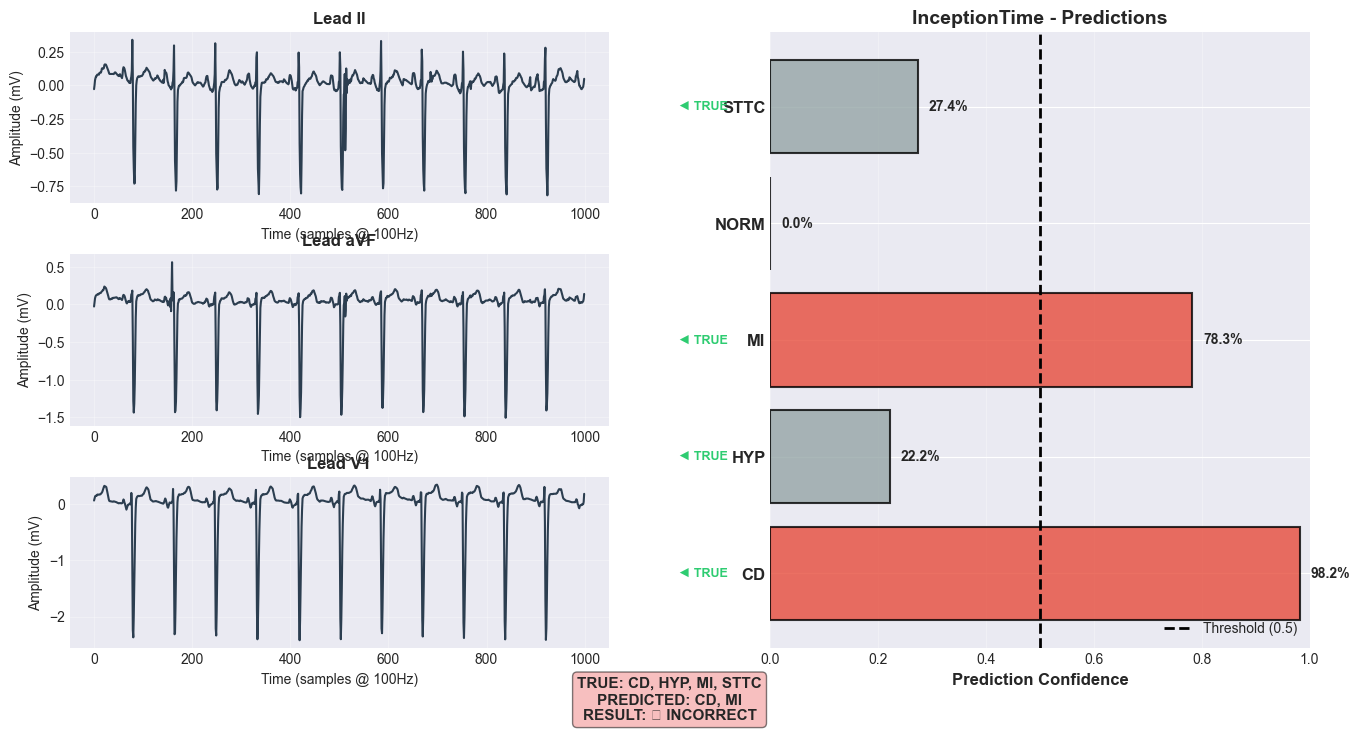


SAMPLE 6


c:\Users\dxkcad1\Desktop\ECGClassificationPreturbation\ECG_Classification_Perturbation\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


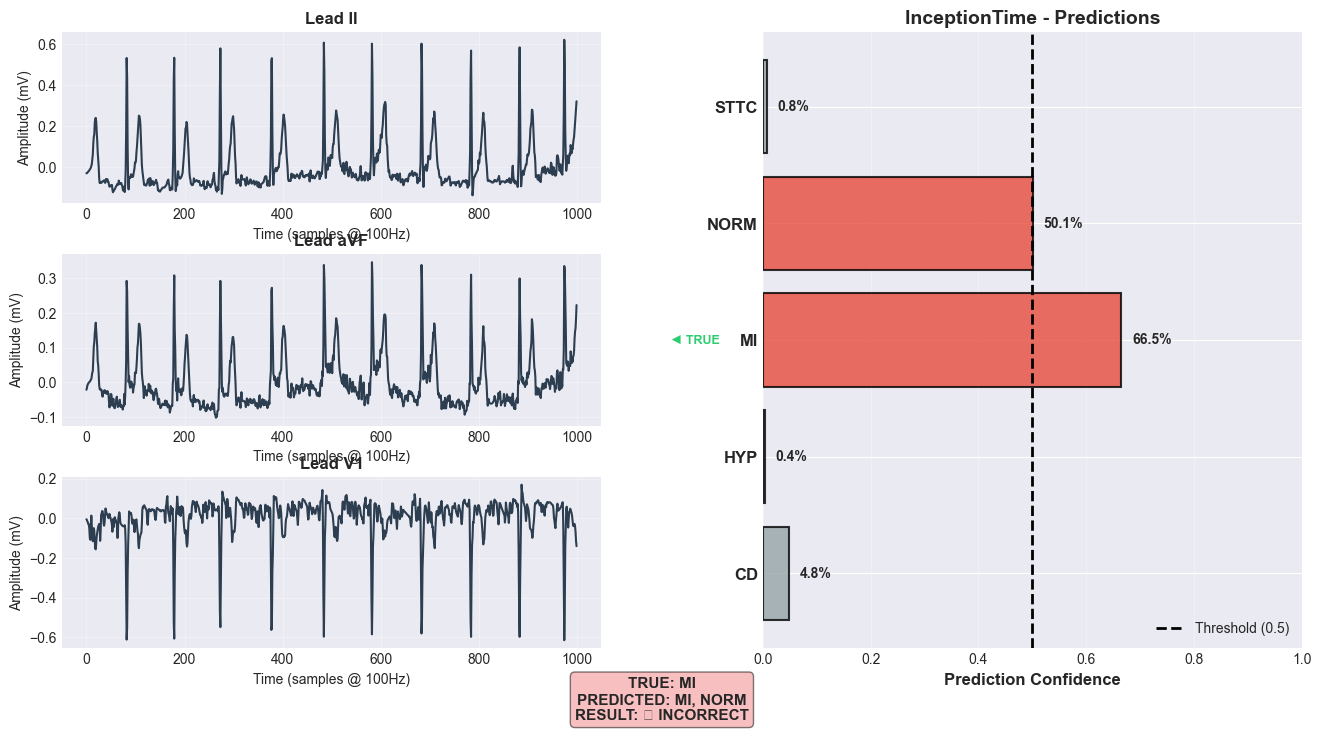

In [38]:
print("="*70)
print("PREDICTION EXAMPLES - VISUALIZING MODEL DECISIONS")
print("="*70)

# Get some interesting test samples
sample_indices = []

# Get one sample from each class
for target_class_idx in range(5):
    for idx in range(len(y_test_enc)):
        if y_test_enc[idx, target_class_idx] == 1:
            sample_indices.append(idx)
            break

# Visualize predictions for each sample
for sample_idx in sample_indices[:3]:  # Show first 3 for now
    print(f"\n{'='*70}")
    print(f"SAMPLE {sample_idx + 1}")
    print(f"{'='*70}")
    
    ecg = X_test[sample_idx]
    true_label = y_test_enc[sample_idx]
    
    # Show InceptionTime prediction (or use model_v2 if inception isn't trained yet)
    try:
        visualize_prediction(ecg, true_label, model_inception, "InceptionTime")
    except:
        visualize_prediction(ecg, true_label, model_v2, "Improved CNN")

In [39]:
def compare_models_on_sample(ecg_signal, true_label, sample_id="Unknown"):
    """
    Compare predictions from all three models on the same ECG
    """
    
    # Get predictions from all models
    pred_baseline = model.predict(ecg_signal.reshape(1, 1000, 12), verbose=0)[0]
    pred_improved = model_v2.predict(ecg_signal.reshape(1, 1000, 12), verbose=0)[0]
    
    try:
        pred_inception = model_inception.predict(ecg_signal.reshape(1, 1000, 12), verbose=0)[0]
        has_inception = True
    except:
        has_inception = False
    
    class_names = ['CD', 'HYP', 'MI', 'NORM', 'STTC']
    
    # Create comparison plot
    fig, axes = plt.subplots(2, 2 if has_inception else 1, figsize=(16, 10))
    
    # Plot one ECG lead as reference
    ax_ecg = axes[0, 0] if has_inception else axes[0]
    ax_ecg.plot(ecg_signal[:, 1], linewidth=1.5, color='#2c3e50')  # Lead II
    ax_ecg.set_title(f'ECG Signal (Lead II) - Sample {sample_id}', fontsize=14, fontweight='bold')
    ax_ecg.set_xlabel('Time (samples @ 100Hz)', fontsize=11)
    ax_ecg.set_ylabel('Amplitude (mV)', fontsize=11)
    ax_ecg.grid(True, alpha=0.3)
    
    # True labels
    true_classes = [class_names[i] for i in range(5) if true_label[i] == 1]
    ax_ecg.text(0.5, -0.15, f'TRUE DIAGNOSIS: {", ".join(true_classes)}', 
                transform=ax_ecg.transAxes, ha='center', fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    # Baseline predictions
    ax1 = axes[0, 1] if has_inception else axes[1]
    bars1 = ax1.bar(class_names, pred_baseline, color='#e74c3c', alpha=0.7, edgecolor='black')
    ax1.set_title('Baseline CNN', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Confidence', fontsize=11)
    ax1.set_ylim([0, 1])
    ax1.axhline(y=0.5, color='black', linestyle='--', linewidth=1.5)
    ax1.grid(axis='y', alpha=0.3)
    
    for bar, prob in zip(bars1, pred_baseline):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height, f'{prob:.2f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Improved CNN predictions
    ax2 = axes[1, 0] if has_inception else None
    if ax2 is not None:
        bars2 = ax2.bar(class_names, pred_improved, color='#f39c12', alpha=0.7, edgecolor='black')
        ax2.set_title('Improved CNN', fontsize=13, fontweight='bold')
        ax2.set_ylabel('Confidence', fontsize=11)
        ax2.set_ylim([0, 1])
        ax2.axhline(y=0.5, color='black', linestyle='--', linewidth=1.5)
        ax2.grid(axis='y', alpha=0.3)
        
        for bar, prob in zip(bars2, pred_improved):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height, f'{prob:.2f}',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # InceptionTime predictions
    if has_inception:
        ax3 = axes[1, 1]
        bars3 = ax3.bar(class_names, pred_inception, color='#2ecc71', alpha=0.7, edgecolor='black')
        ax3.set_title('InceptionTime', fontsize=13, fontweight='bold')
        ax3.set_ylabel('Confidence', fontsize=11)
        ax3.set_ylim([0, 1])
        ax3.axhline(y=0.5, color='black', linestyle='--', linewidth=1.5)
        ax3.grid(axis='y', alpha=0.3)
        
        for bar, prob in zip(bars3, pred_inception):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height, f'{prob:.2f}',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\nPREDICTION SUMMARY:")
    print("-" * 70)
    print(f"{'Model':<20} {'Predicted Classes':<30} {'Correct?':<10}")
    print("-" * 70)
    
    pred_base_classes = [class_names[i] for i in range(5) if pred_baseline[i] > 0.5]
    pred_imp_classes = [class_names[i] for i in range(5) if pred_improved[i] > 0.5]
    
    print(f"{'Baseline CNN':<20} {', '.join(pred_base_classes) if pred_base_classes else 'None':<30} "
          f"{'✓' if set(pred_base_classes) == set(true_classes) else '✗':<10}")
    print(f"{'Improved CNN':<20} {', '.join(pred_imp_classes) if pred_imp_classes else 'None':<30} "
          f"{'✓' if set(pred_imp_classes) == set(true_classes) else '✗':<10}")
    
    if has_inception:
        pred_inc_classes = [class_names[i] for i in range(5) if pred_inception[i] > 0.5]
        print(f"{'InceptionTime':<20} {', '.join(pred_inc_classes) if pred_inc_classes else 'None':<30} "
              f"{'✓' if set(pred_inc_classes) == set(true_classes) else '✗':<10}")
    
    print("-" * 70)

print("✓ Model comparison function created!")

✓ Model comparison function created!


MODEL COMPARISON ON SPECIFIC EXAMPLES

 Finding interesting test cases...

 CASE 1: Clear Normal ECG


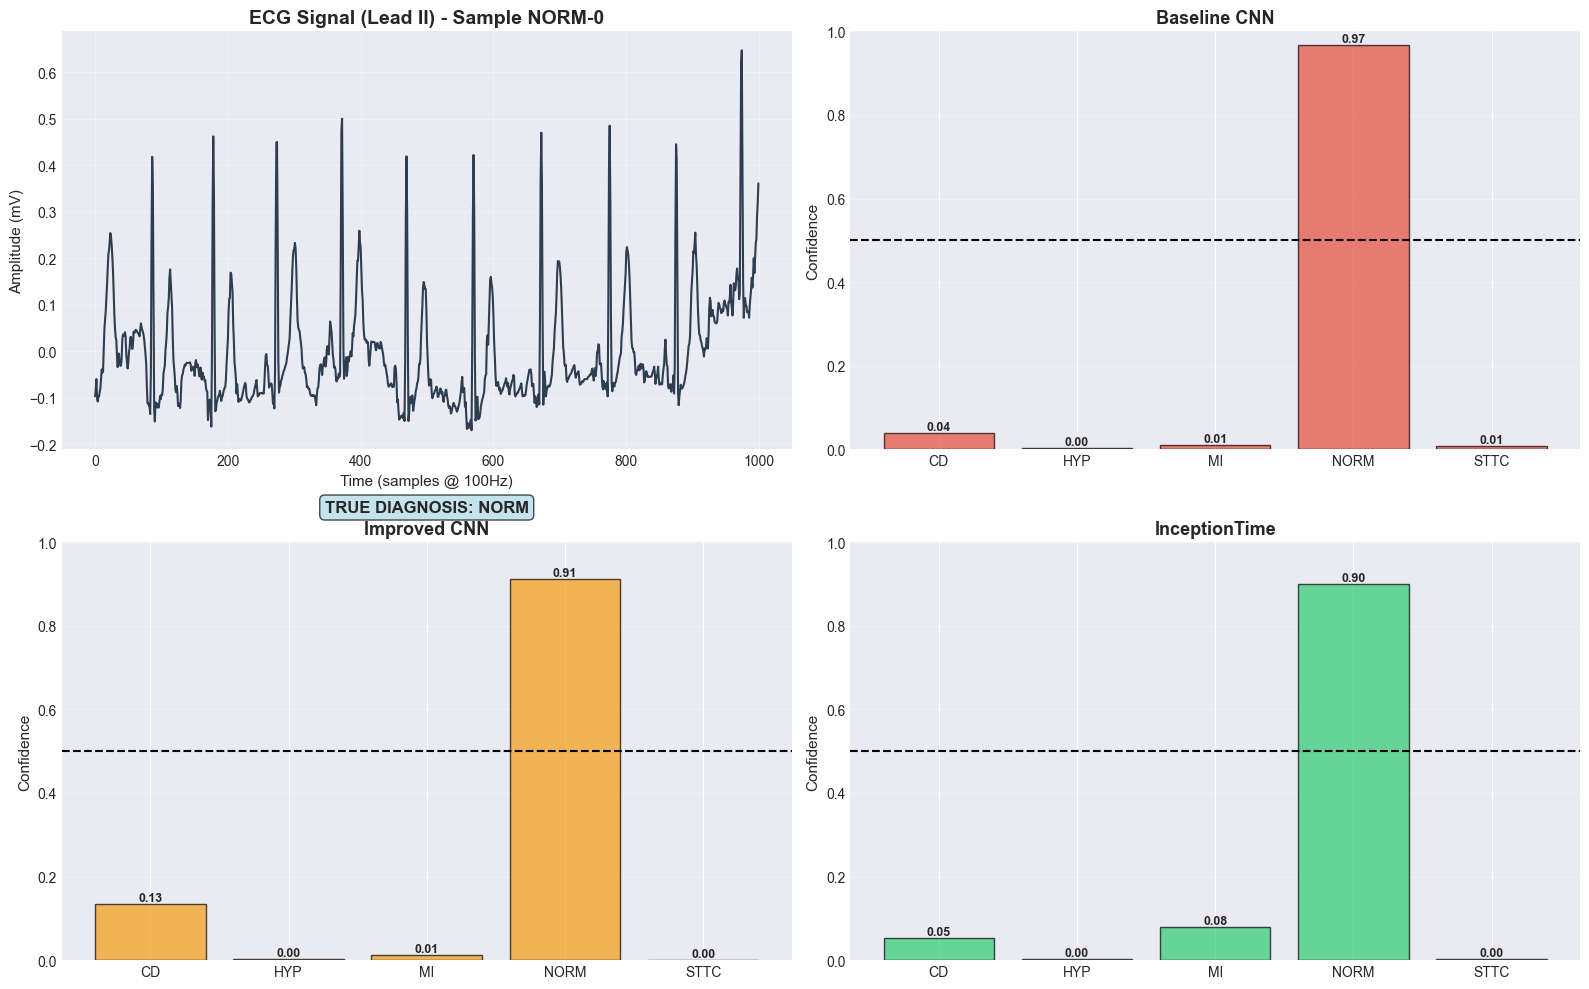


PREDICTION SUMMARY:
----------------------------------------------------------------------
Model                Predicted Classes              Correct?  
----------------------------------------------------------------------
Baseline CNN         NORM                           ✓         
Improved CNN         NORM                           ✓         
InceptionTime        NORM                           ✓         
----------------------------------------------------------------------

 CASE 2: Clear Myocardial Infarction


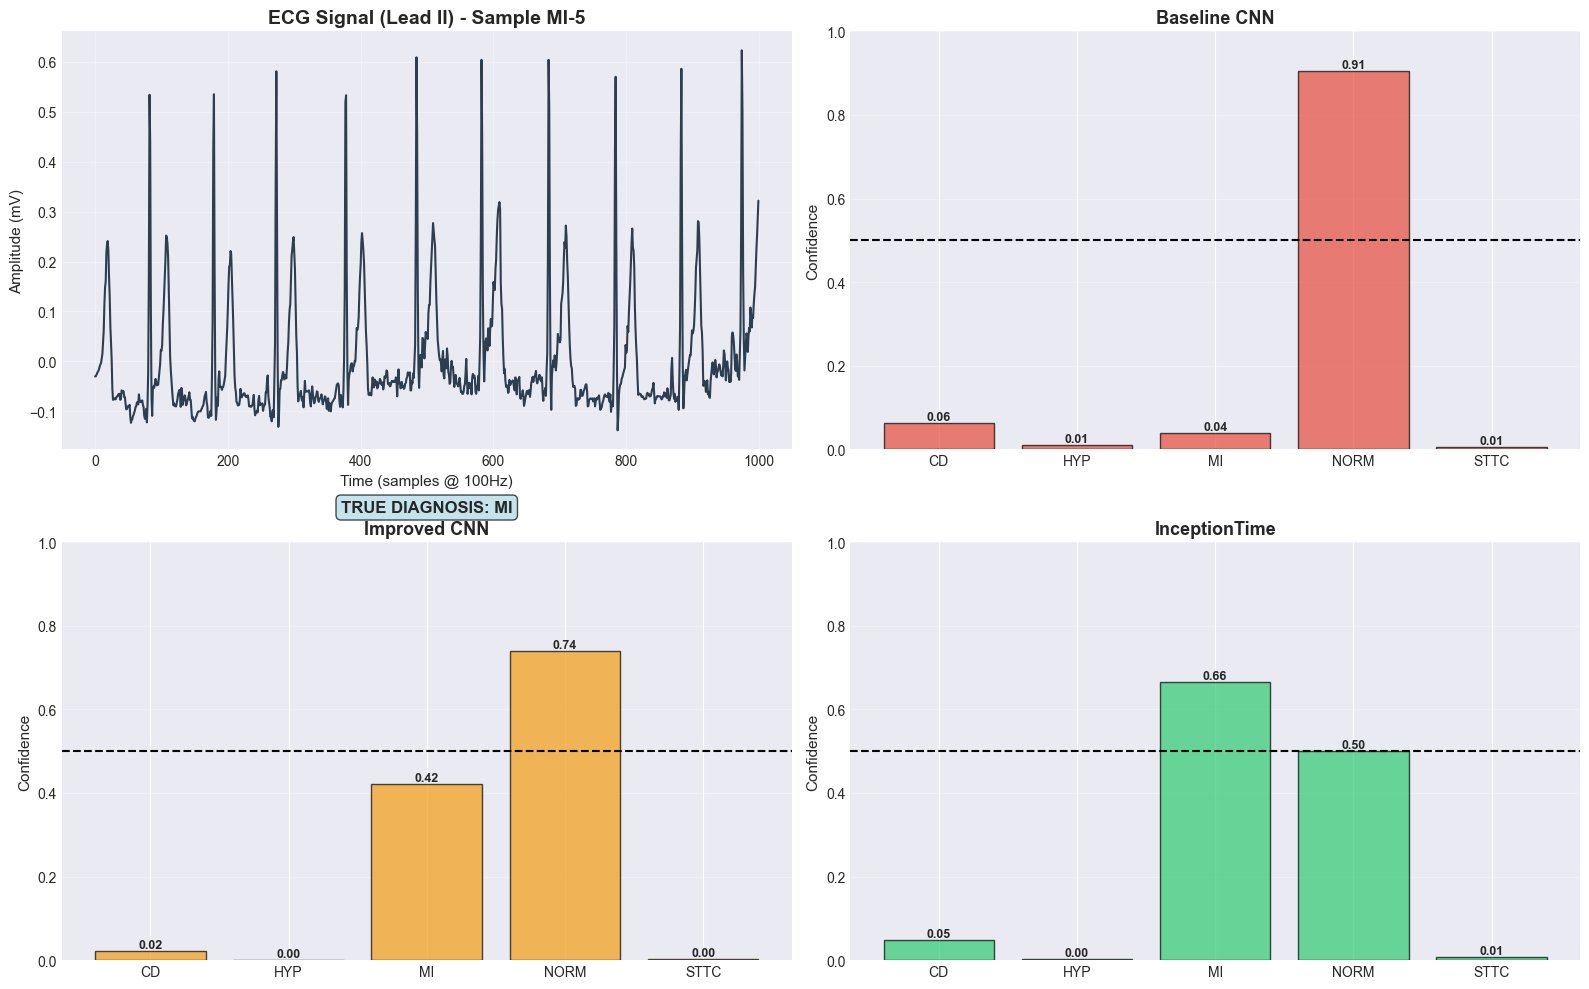


PREDICTION SUMMARY:
----------------------------------------------------------------------
Model                Predicted Classes              Correct?  
----------------------------------------------------------------------
Baseline CNN         NORM                           ✗         
Improved CNN         NORM                           ✗         
InceptionTime        MI, NORM                       ✗         
----------------------------------------------------------------------

 CASE 3: Multiple Conditions


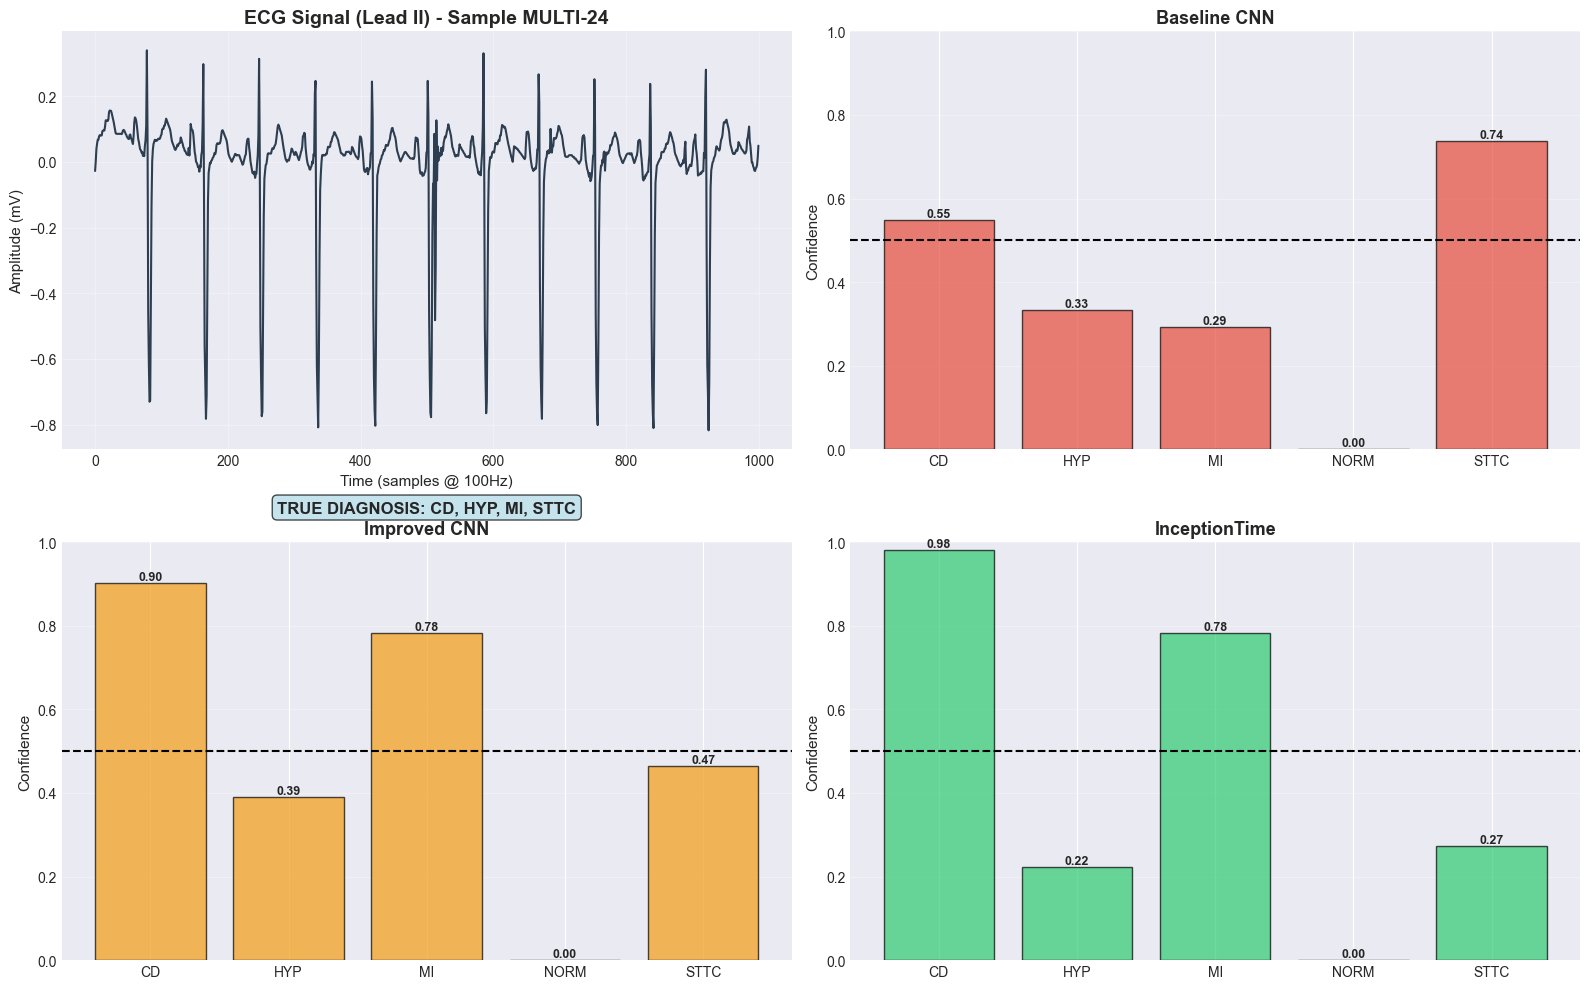


PREDICTION SUMMARY:
----------------------------------------------------------------------
Model                Predicted Classes              Correct?  
----------------------------------------------------------------------
Baseline CNN         CD, STTC                       ✗         
Improved CNN         CD, MI                         ✗         
InceptionTime        CD, MI                         ✗         
----------------------------------------------------------------------


In [40]:
print("="*70)
print("MODEL COMPARISON ON SPECIFIC EXAMPLES")
print("="*70)

# Find interesting cases
print("\n Finding interesting test cases...")

# Case 1: A clear NORM case
for idx in range(len(y_test_enc)):
    if y_test_enc[idx, 3] == 1 and y_test_enc[idx].sum() == 1:  # Pure NORM
        print("\n CASE 1: Clear Normal ECG")
        compare_models_on_sample(X_test[idx], y_test_enc[idx], f"NORM-{idx}")
        break

# Case 2: A clear MI case
for idx in range(len(y_test_enc)):
    if y_test_enc[idx, 2] == 1 and y_test_enc[idx].sum() == 1:  # Pure MI
        print("\n CASE 2: Clear Myocardial Infarction")
        compare_models_on_sample(X_test[idx], y_test_enc[idx], f"MI-{idx}")
        break

# Case 3: Multi-label case
for idx in range(len(y_test_enc)):
    if y_test_enc[idx].sum() > 1:  # Multiple conditions
        print("\n CASE 3: Multiple Conditions")
        compare_models_on_sample(X_test[idx], y_test_enc[idx], f"MULTI-{idx}")
        break